<a href="https://colab.research.google.com/github/SamwelMakombe-cloud/ce-colab-notebooks/blob/main/heart_ultrasound_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Installing required packages.

In [ ]:
!pip install scikit-learn
!pip install scipy
!pip install plotly_express
!pip install scikeras # Install the missing 'scikeras' package

#### Module Imports and Environment Setup

In [ ]:


# ================================
# === FILE AND SYSTEM HANDLING ===
# ================================
import os                                # File system operations
import zipfile                           # Extracting files from ZIP archives
from google.colab import files           # File upload/download in Google Colab
from google.colab import drive           # Mount Google Drive

# ===============================
# === GENERAL UTILITIES ===
# ===============================
import time                              # Timing operations
import warnings                          # Warning control
from tqdm import tqdm                    # Progress bar

# ===============================
# === NUMERICAL & DATA TOOLS ===
# ===============================
import numpy as np                       # Array operations
import pandas as pd                      # Data manipulation

# ================================
# === IMAGE PROCESSING & VISUALS ===
# ================================
import cv2                               # Image processing
from PIL import Image                    # Image loading and format conversions
from skimage import feature, exposure    # HOG features and contrast enhancement
import matplotlib.pyplot as plt          # Plotting (static)
import seaborn as sns                    # Advanced statistical plots
import plotly_express as px              # Interactive plots

# ===============================
# === FEATURE ENGINEERING ===
# ===============================
from skimage.feature import hog          # HOG feature extraction
from sklearn.preprocessing import (
    StandardScaler, LabelEncoder
)                                        # Scaling & encoding
from sklearn.decomposition import PCA    # Dimensionality reduction
from sklearn.utils import (
    resample, shuffle, class_weight
)                                        # Resampling, shuffling, class weights
from sklearn.utils.class_weight import compute_class_weight

# ================================
# === MODEL TRAINING & EVALUATION ===
# ================================
from sklearn.model_selection import (
    train_test_split, cross_validate, cross_val_score,
    StratifiedKFold
)                                        # Train-test splitting and CV

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_curve, auc
)                                        # Evaluation metrics

# ================================
# === MACHINE LEARNING MODELS ===
# ================================
from sklearn.svm import SVC              # Support Vector Machine
from sklearn.cluster import KMeans       # Clustering
from sklearn import datasets             # Built-in datasets

# ================================
# === DEEP LEARNING: KERAS/TENSORFLOW ===
# ================================
import tensorflow as tf                                  # TensorFlow backend
from tensorflow import keras                             # Keras high-level API
from tensorflow.keras import layers, models, backend as K # Layers and backend
from tensorflow.keras.models import Model, Sequential     # Model types
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Dropout,
    Flatten, Dense
)                                                        # CNN Layers
from tensorflow.keras.preprocessing.image import (
    ImageDataGenerator, array_to_img
)                                                        # Image augmentation and conversion
from tensorflow.keras.optimizers import Adam, AdamW       # Optimizers
from tensorflow.keras.utils import to_categorical         # One-hot encoding
from keras.models import Sequential                       # Sequential model from Keras
from keras.layers import (
    Conv2D, MaxPooling2D, Dropout,
    Flatten, Dense
)                                                        # CNN Layers from Keras
from keras.utils import to_categorical                    # One-hot encoding (Keras version)
from keras import utils                                   # Utility functions
from keras.datasets import mnist                          # MNIST dataset

# ================================
# === Machine Learning & Evaluation (Scikit-learn) ===
# ================================
from sklearn import datasets                             # Built-in datasets
from sklearn.utils import resample, shuffle              # Dataset balancing and randomness
from sklearn.utils import class_weight, shuffle          # Class weight for imbalanced data
from sklearn.preprocessing import StandardScaler         # Feature scaling
from sklearn.preprocessing import LabelEncoder           # Encoding categorical labels
from sklearn.decomposition import PCA                    # Dimensionality reduction
from sklearn.model_selection import (
    train_test_split, cross_validate, cross_val_score,
    StratifiedKFold
)                                                        # Data splitting and validation
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, confusion_matrix,
    roc_curve, auc
)                                                        # Evaluation metrics
from sklearn.cluster import KMeans                       # Unsupervised clustering
from sklearn.svm import SVC

# ================================
# === NOTEBOOK HANDLING ===
# ================================
import io
import nbformat                              # For reading and ipynb and py notebooks
from nbformat import current

# ================================
# === SPECIFIC APPLICATIONS ===
# ================================
# -- Classification:
# Used for traditional ML (SVM, KMeans) and deep learning (CNN, ResNet, etc.)

# -- U-Net Segmentation:
# (Libraries like TensorFlow, Keras used to define U-Net architecture)

# -- CNN / ResNet / Deep Learning Models:
# Used tf.keras.models.Sequential / Model
# Layers include Conv2D, MaxPooling2D, Dropout, Flatten, Dense

# -- Cross-validation:
# Used train_test_split, StratifiedKFold, cross_validate, cross_val_score

# -- Evaluation & Heatmaps:
# Used seaborn, confusion_matrix, roc_curve, auc, classification_report, and accuracy_score

# -- Image Preprocessing and Feature Extraction:
# Used OpenCV, HOG features, StandardScaler, PCA


#### Total word Count

In [ ]:
filepath = '/content/drive/MyDrive/coursework/coursework_cmm536.ipynb'

with io.open(filepath, 'r', encoding='utf-8') as f:
    nb = current.read(f, 'ipynb')

word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print(word_count)

1026


# **EXPERIMENT ONE**

#### Loading the Folder Data from Drive and Verifying Successful Import

In [ ]:
drive.mount('/content/drive')  # Mount the user's Google Drive to /content/drive

Mounted at /content/drive


In [ ]:
# Define base data directory
data_dir = "/content/drive/MyDrive/data_cw/data"

# List all items in the data directory
data_contents = os.listdir(data_dir)
print("Contents of base data directory:", data_contents)


# Load heart and non-heart images
heart_dir = os.path.join(data_dir, "heart")
non_heart_dir = os.path.join(data_dir, "non-heart")

heart_images = os.listdir(heart_dir)
non_heart_images = os.listdir(non_heart_dir)


# Count the number of images in each heart subcategory
heart_subdirs = ["closed", "open", "various"]
heart_counts = {
    subdir: len(os.listdir(os.path.join(heart_dir, subdir)))
    for subdir in heart_subdirs
}


# Count total non-heart images
non_heart_count = len(non_heart_images)


# Display counts
print("Heart image counts by category:", heart_counts)
print("Total non-heart images:", non_heart_count)

Contents of base data directory: ['heart', 'non-heart']
Heart image counts by category: {'closed': 80, 'open': 138, 'various': 5}
Total non-heart images: 925


#### Loading and Exploring Sample Images from Each Class

Heart Closed Image - Pixel values: 
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [1 1 1]
  [1 1 1]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [1 1 1]
  [1 1 1]]

 [[1 1 1]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


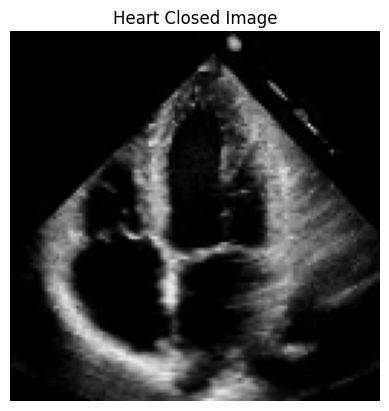

Heart Open Image - Pixel values: 
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[1 1 1]
  [1 1 1]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[1 1 1]
  [1 1 1]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


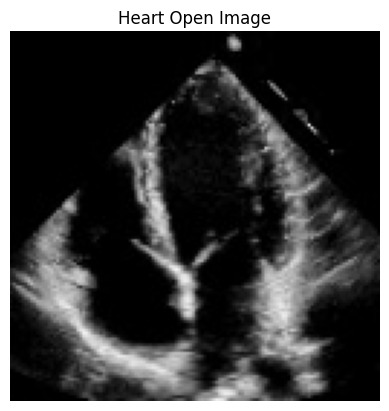

Non-Heart Image - Pixel values: 
[[[10 10 10]
  [10 10 10]
  [10 10 10]
  ...
  [10 10 10]
  [10 10 10]
  [10 10 10]]

 [[10 10 10]
  [10 10 10]
  [10 10 10]
  ...
  [10 10 10]
  [10 10 10]
  [10 10 10]]

 [[10 10 10]
  [10 10 10]
  [10 10 10]
  ...
  [10 10 10]
  [10 10 10]
  [10 10 10]]

 ...

 [[10 10 10]
  [10 10 10]
  [10 10 10]
  ...
  [10 10 10]
  [10 10 10]
  [10 10 10]]

 [[10 10 10]
  [10 10 10]
  [10 10 10]
  ...
  [10 10 10]
  [10 10 10]
  [10 10 10]]

 [[10 10 10]
  [10 10 10]
  [10 10 10]
  ...
  [10 10 10]
  [10 10 10]
  [10 10 10]]]


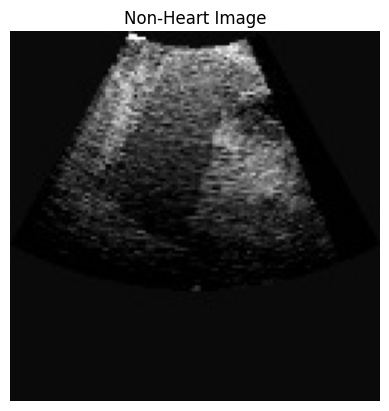

Heart Closed Image - Min pixel value: 0, Max pixel value: 236
Heart Open Image - Min pixel value: 0, Max pixel value: 246
Non-Heart Image - Min pixel value: 0, Max pixel value: 255
Heart Closed Image - Image shape: (128, 128, 3)
Heart Open Image - Image shape: (128, 128, 3)
Non-Heart Image - Image shape: (128, 128, 3)
Type of Heart Closed Image: <class 'numpy.ndarray'>
Type of Heart Open Image: <class 'numpy.ndarray'>
Type of Non-Heart Image: <class 'numpy.ndarray'>


In [ ]:
# Define the image paths
heart_closed_dir = '/content/drive/MyDrive/data_cw/data/heart/closed/5.jpg'
heart_open_dir = '/content/drive/MyDrive/data_cw/data/heart/open/1.jpg'
non_heart_dir = '/content/drive/MyDrive/data_cw/data/non-heart/1.jpg'

# Load images from each folder
heart_closed_image = cv2.imread(heart_closed_dir)
heart_open_image = cv2.imread(heart_open_dir)
non_heart_image = cv2.imread(non_heart_dir)

# Visualize the images and print the pixel values
def display_image(image, title):
    print(f"{title} - Pixel values: \n{image}")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

# Display images
display_image(heart_closed_image, "Heart Closed Image")
display_image(heart_open_image, "Heart Open Image")
display_image(non_heart_image, "Non-Heart Image")

# Print pixel value range for each image
def print_pixel_range(image, title):
    print(f"{title} - Min pixel value: {image.min()}, Max pixel value: {image.max()}")

print_pixel_range(heart_closed_image, "Heart Closed Image")
print_pixel_range(heart_open_image, "Heart Open Image")
print_pixel_range(non_heart_image, "Non-Heart Image")

# Check the shape structure of each image
def print_image_shape(image, title):
    print(f"{title} - Image shape: {image.shape}")

print_image_shape(heart_closed_image, "Heart Closed Image")
print_image_shape(heart_open_image, "Heart Open Image")
print_image_shape(non_heart_image, "Non-Heart Image")

# Check the type of the images
print(f"Type of Heart Closed Image: {type(heart_closed_image)}")
print(f"Type of Heart Open Image: {type(heart_open_image)}")
print(f"Type of Non-Heart Image: {type(non_heart_image)}")


#### Image Preprocessing and Label Assignment for both HOG-SVM and CNN Models

In [ ]:
# Keep original image dimensions as per the dataset description
img_width, img_height = 128, 128

# Set data directories
base_path = '/content/drive/MyDrive/data_cw/data'
heart_closed_dir = os.path.join(base_path, 'heart/closed')
heart_open_dir = os.path.join(base_path, 'heart/open')
non_heart_dir = os.path.join(base_path, 'non-heart')

# Label mapping: 1 = heart (closed or open), 0 = non-heart
label_map = {
    heart_closed_dir: 1,
    heart_open_dir: 1,
    non_heart_dir: 0
}

# Lists to store data
images_raw = []        #  3D array of grayscale images
targets = []           # Labels (0 or 1)

# Load and process images
for dir_path, label in label_map.items():
    for filename in os.listdir(dir_path):
        file_path = os.path.join(dir_path, filename)
        try:
            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                raise ValueError("Image not loaded properly")
            if img.shape != (img_height, img_width):
                raise ValueError(f"Unexpected shape {img.shape} in {filename}")
            images_raw.append(img)  # Original shape for CNN
            targets.append(label)
        except Exception as e:
            print(f"Error loading image {filename}: {e}")

# Convert to NumPy arrays
images_raw = np.array(images_raw)  # shape: (N, 128, 128)
targets = np.array(targets)  # shape: (N,)

# Output shape info
print("Shape of raw images array :", images_raw.shape) ## This array will be processed for HOG/SVM, #and later for CNN
print("Target labels shape:", targets.shape)
print(f"Heart images count: {np.sum(targets == 1)}")
print(f"Non-heart images count: {np.sum(targets == 0)}")


Shape of raw images array : (1143, 128, 128)
Target labels shape: (1143,)
Heart images count: 218
Non-heart images count: 925


### SVM (Linear Model)

SVMs and other non-neural models can't learn features directly from raw pixel data, so they rely on techniques like HOG to manually extract informative features such as edges and textures for effective classification.

Hence, the first step will be feature extraction using HOG.

Training set - Heart images: 163, Non-heart images: 694
Testing set - Heart images: 55, Non-heart images: 231


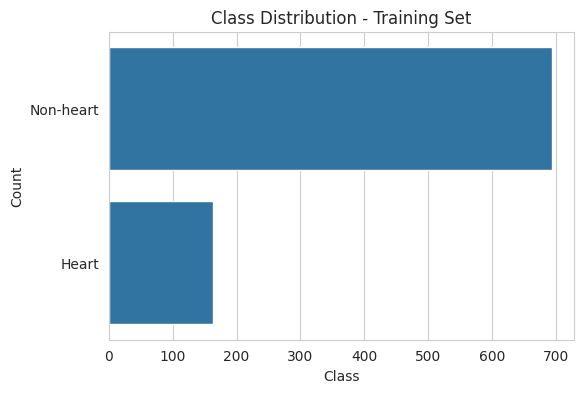

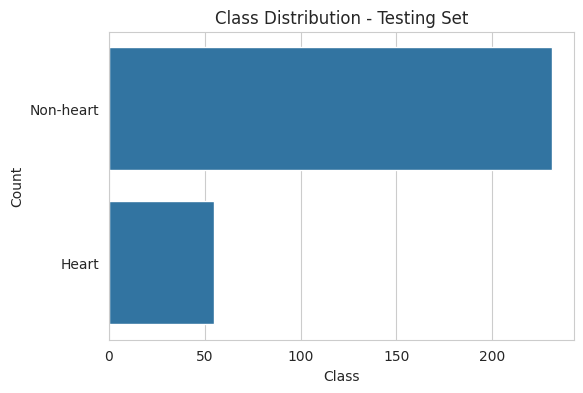

HOG Features for the image:
[0. 0. 0. ... 0. 0. 0.]
Size of the HOG Features for the image: (8100,)
Shape of training HOG features: (857, 8100)
Shape of testing HOG features: (286, 8100)


In [ ]:
# =================================================================================
# ============================ IMAGE LOADING & SPLITTING ==========================
# =================================================================================
# Shuffle Dataset to Ensure Randomness
all_images, all_labels = shuffle(images_raw, targets, random_state=42)   # Shuffling to avoid any ordering bias from the original dataset

# Split Dataset into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(
    all_images, all_labels, stratify=all_labels, test_size=0.25, random_state=42  # stratified 75/25 train/test
)

# Display the Class Distribution in Training and Testing Sets
print(f"Training set - Heart images: {np.count_nonzero(np.array(y_train) == 1)}, Non-heart images: {np.count_nonzero(np.array(y_train) == 0)}")
print(f"Testing set - Heart images: {np.count_nonzero(np.array(y_test) == 1)}, Non-heart images: {np.count_nonzero(np.array(y_test) == 0)}")

# Plot class distribution for the training set
import seaborn as sns
import matplotlib.pyplot as plt

train_labels = ['Heart' if label == 1 else 'Non-heart' for label in y_train]
sns.set_style('whitegrid')
plt.figure(figsize=(6, 4))
sns.countplot(train_labels)
plt.title("Class Distribution - Training Set")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

# Plot class distribution for the testing set
test_labels = ['Heart' if label == 1 else 'Non-heart' for label in y_test]
plt.figure(figsize=(6, 4))
sns.countplot(test_labels)
plt.title("Class Distribution - Testing Set")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()




# =====================================================================================
# ============================ FEATURES EXTRACTION USING HOG ==========================
# =====================================================================================

warnings.simplefilter('ignore') # Suppress Warnings

# HOG Definition
class HOG:
    def __init__(self, orientations=9, pixelsPerCell=(8, 8), cellsPerBlock=(2, 2), transform=False):
        self.orientations = orientations
        self.pixelsPerCell = pixelsPerCell
        self.cellsPerBlock = cellsPerBlock
        self.transform = transform

    def describe(self, image):
        # Compute Histogram of Oriented Gradients for edge and texture representation
        hist = feature.hog(image,
                           orientations=self.orientations,
                           pixels_per_cell=self.pixelsPerCell,
                           cells_per_block=self.cellsPerBlock,
                           transform_sqrt=self.transform)
        return hist

# Initialize HOG Descriptor
hog = HOG(orientations=9, pixelsPerCell=(8, 8), cellsPerBlock=(2, 2), transform=True)

#  Extract HOG Features for One Image from Training Set
img = X_train[0]  # Use a sample image to preview HOG feature vector
hist = hog.describe(img)  # Extract and display HOG features
print('HOG Features for the image:')
print(hist)
print('Size of the HOG Features for the image:', hist.shape)

# Extract HOG Features for All Training and Testing Images
X_train_hog = np.array([hog.describe(image) for image in X_train])  # Loop through all training images
X_test_hog = np.array([hog.describe(image) for image in X_test])    # Loop through all test images

#  Output Shape Info for HOG Features
print("Shape of training HOG features:", X_train_hog.shape)
print("Shape of testing HOG features:", X_test_hog.shape)


- The imbalance in this dataset may lead classification models to focus more on non-heart patterns and struggle to accurately detect heart images.

Below is SVM training for this dataset.

In [ ]:
# Initialize the SVM classifier with a linear kernel
model = SVC(kernel='linear')

# Train the SVM model using the HOG features extracted from training data
clf = model.fit(X_train_hog, y_train)

# Use the trained model to predict labels for the test set
y_predicted = model.predict(X_test_hog)

# Print predictions
print(y_predicted)
print("Predicted shape:", y_predicted.shape)

# Calculate and print overall accuracy by comparing predictions with ground truth
comparison = y_predicted == y_test
print('Accuracy:', sum(comparison) / len(comparison))

# Calculate and print class-wise accuracy where '1' = Heart and '0' = Non-Heart
print('Heart Acc:', sum(y_test[np.where(y_test == 1)] == y_predicted[np.where(y_test == 1)]) / len(y_test[np.where(y_test == 1)]))
print('Non-Heart Acc:', sum(y_test[np.where(y_test == 0)] == y_predicted[np.where(y_test == 0)]) / len(y_test[np.where(y_test == 0)]))

# Flatten the arrays to ensure they are 1D for metric calculations
y_test = y_test.flatten()
y_predicted = y_predicted.flatten()

# Print standard evaluation metrics for classification performance
print("SVM Performance Metrics on test :")
print("Precision:", precision_score(y_test, y_predicted))
print("Recall:", recall_score(y_test, y_predicted))
print("F1-Score:", f1_score(y_test, y_predicted))


[0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 1 0 0 1 0 0 0 0 0 1 1 0 0
 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0
 0 0 1 0 0 0 0 1 0 0 1 0 0 1 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 1
 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1
 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0
 0 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0]
Predicted shape: (286,)
Accuracy: 1.0
Heart Acc: 1.0
Non-Heart Acc: 1.0
SVM Performance Metrics on test :
Precision: 1.0
Recall: 1.0
F1-Score: 1.0


- The SVM achieved perfect scores on all test metrics despite the imbalanced dataset, but to better interpret SVM decisions, PCA will reduce HOG features to two dimensions for boundary visualization.

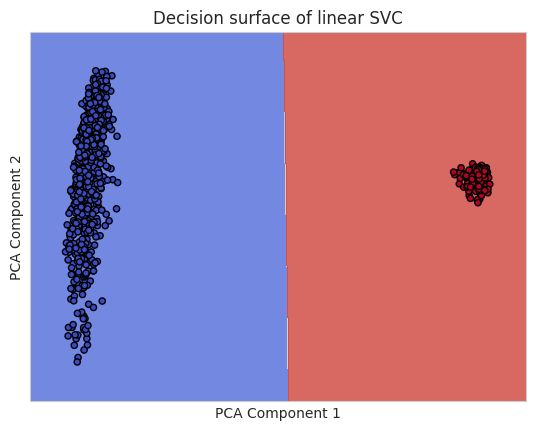

In [ ]:
# Apply PCA only for visualization (reducing dimensions to 2D)
pca = PCA(n_components=2)
X_train_hog_pca = pca.fit_transform(X_train_hog)
X_test_hog_pca = pca.transform(X_test_hog)

# Train the SVM model with the PCA-reduced HOG features
clf_pca = model.fit(X_train_hog_pca, y_train)

# This is to visualize how the classifier separates the classes
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

# Function to plot the SVM decision boundary over the meshgrid
def plot_contours(ax, clf_pca, xx, yy, **params):
    Z = clf_pca.predict(np.c_[xx.ravel(), yy.ravel()]) # Predict labels for each point in the mesh
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return

# Create a plot with the mesh grid and the contours
fig, ax = plt.subplots()
title = ('Decision surface of linear SVC')

# Generate meshgrid using the first two PCA components
xx, yy = make_meshgrid(X_train_hog_pca[:, 0], X_train_hog_pca[:, 1])

# Plot decision boundaries and training data
plot_contours(ax, clf_pca, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X_train_hog_pca[:, 0], X_train_hog_pca[:, 1], c=y_train, cmap=plt.cm.coolwarm, s=20, edgecolors='k')

# Set labels and title for clarity
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)

# Show the final plot
plt.show()

- The red and blue regions clearly show separable predicted classes, suggesting that the model has learned an effective decision boundary. Therefore, 5-fold validation is needed to ensure a more reliable assessment.

In [ ]:
# 5-fold Cross-validation evaluation for SVM
scores_svm = cross_validate(model, X_train_hog, y_train, cv=5, scoring=['accuracy', 'precision', 'recall', 'f1'])
print('SVM cross-validated scores:', scores_svm)

# Evaluating Accuracy for each fold
print('Accuracy for SVM:', cross_val_score(model, X_train_hog, y_train, cv=5, scoring='accuracy'))

# Evaluating Precision, Recall, and F1-score (both by fold and average)
print('Precision for SVM:', cross_val_score(model, X_train_hog, y_train, cv=5, scoring='precision'))
print('Recall for SVM:', cross_val_score(model, X_train_hog, y_train, cv=5, scoring='recall'))
print('F1-Score for SVM:', cross_val_score(model, X_train_hog, y_train, cv=5, scoring='f1'))

# Evaluating Mean values for all folds
print('Mean Accuracy for SVM:', np.mean(cross_val_score(model, X_train_hog, y_train, cv=5, scoring='accuracy')))
print('Mean Precision for SVM:', np.mean(cross_val_score(model, X_train_hog, y_train, cv=5, scoring='precision')))
print('Mean Recall for SVM:', np.mean(cross_val_score(model, X_train_hog, y_train, cv=5, scoring='recall')))
print('Mean F1-Score for SVM:', np.mean(cross_val_score(model, X_train_hog, y_train, cv=5, scoring='f1')))

SVM cross-validated scores: {'fit_time': array([0.59272599, 0.39137125, 0.59579825, 0.2887578 , 0.28889871]), 'score_time': array([0.09855247, 0.07029104, 0.04943371, 0.04809666, 0.05388188]), 'test_accuracy': array([1., 1., 1., 1., 1.]), 'test_precision': array([1., 1., 1., 1., 1.]), 'test_recall': array([1., 1., 1., 1., 1.]), 'test_f1': array([1., 1., 1., 1., 1.])}
Accuracy for SVM: [1. 1. 1. 1. 1.]
Precision for SVM: [1. 1. 1. 1. 1.]
Recall for SVM: [1. 1. 1. 1. 1.]
F1-Score for SVM: [1. 1. 1. 1. 1.]
Mean Accuracy for SVM: 1.0
Mean Precision for SVM: 1.0
Mean Recall for SVM: 1.0
Mean F1-Score for SVM: 1.0


- The mean values for these metrics in the 5-fold cross-validation indicates that SVM model has also achieved perfect results.

### Vanilla Convulation Neural Network (CNN)

A vanilla CNN, a simpler neural network, has been chosen for this task, given the problem's simplification observed from the SVM results.

For the preprocessing,The CNN will automatically learn hierarchical patterns directly from raw images.

In [ ]:
# Shuffle dataset to ensure randomness
all_images, all_labels = shuffle(images_raw, targets, random_state=42) # Uses raw images and corresponding labels

# Split the dataset into training and testing sets while preserving the class distribution
X_train, X_test, y_train, y_test = train_test_split(
    all_images, all_labels, stratify=all_labels, test_size=0.25, random_state=42 # stratified 75/25 train/test
)

# Display the class distribution in the training and testing sets
print(f"Training set - Heart images: {np.count_nonzero(np.array(y_train) == 1)}, Non-heart images: {np.count_nonzero(np.array(y_train) == 0)}")
print(f"Testing set - Heart images: {np.count_nonzero(np.array(y_test) == 1)}, Non-heart images: {np.count_nonzero(np.array(y_test) == 0)}")

# Convert grayscale images to RGB by repeating the single channel across 3 channels (required for CNN input)
X_train = np.repeat(X_train[..., np.newaxis], 3, axis=-1)
X_test = np.repeat(X_test[..., np.newaxis], 3, axis=-1)

# Normalize pixel values to the range [0, 1] and ensure data type is float32 (standard input format for neural networks)
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255


# Convert labels to one-hot encoded format for binary classification
y_train = utils.to_categorical(y_train, 2)  # 2 for binary classification
y_test = utils.to_categorical(y_test, 2)  # 2 for binary classification

# Print the final shapes of the training and testing datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

Training set - Heart images: 163, Non-heart images: 694
Testing set - Heart images: 55, Non-heart images: 231
X_train shape: (857, 128, 128, 3), y_train shape: (857, 2)
X_test shape: (286, 128, 128, 3), y_test shape: (286, 2)


This CNN used below is straightforward, consisting of only two convolutional layers and standard components like Conv2D, MaxPooling2D, Dropout, and Dense, along with basic regularization techniques.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 124, 124, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 123008)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    15,745,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,755,554 (60.10 MB)

 Trainable params: 15,755,554 (60.10 MB)

 Non-trainable params: 0 (0.00 B)

Loss: 0.0
Accuracy: 1.0


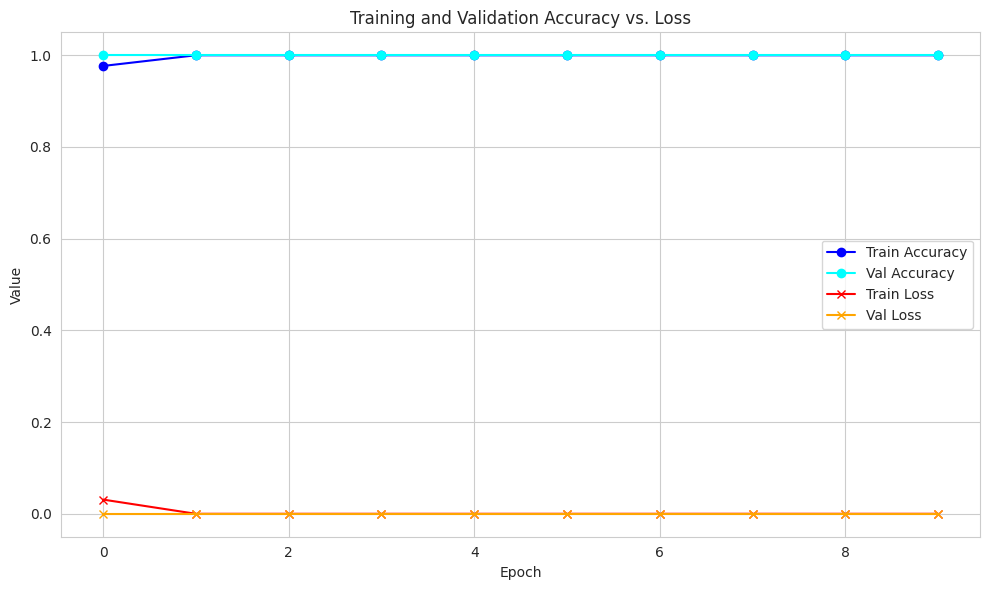

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step

NN Performance Metrics:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-Score: 1.0


In [ ]:
# Define the Convolutional Neural Network (CNN) model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)), # First convolutional layer with ReLU activation function
    Conv2D(32, (3, 3), activation='relu'),                            # Second convolutional layer with ReLU activation function

    MaxPooling2D(pool_size=(2, 2)),                                   # Max pooling layer to reduce spatial dimensions

    Dropout(0.25),                                                    # Dropout layer to prevent overfitting

    Flatten(),                                                        # Flatten the output for fully connected layers

    Dense(128, activation='relu'),                                    # Fully connected (dense) layer with 128 units and ReLU activation

    Dropout(0.5),                                                     # Dropout layer to prevent overfitting

    Dense(2, activation='softmax')                                    # Output layer with 2 units (binary classification) and softmax activation
])


# Compile the model with categorical crossentropy loss function, Adam optimizer, and accuracy metric
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])


# Print the model summary to view the architecture and parameters
model.summary()


# Train the model on the training data, validating on the test set and storing the training history
history = model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=0, validation_data=(X_test, y_test)) # verbose=0 for a clean output and while tracking the progress visually using plots


# Evaluate the model's performance on the test set
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Loss: {loss}\nAccuracy: {accuracy}')


# Convert the training history into a Pandas DataFrame for easier visualization
losses = pd.DataFrame(history.history)


# Plot training and validation accuracy vs. loss for each epoch
plt.figure(figsize=(10, 6))
plt.plot(losses.index, losses['accuracy'], label='Train Accuracy', color='blue', marker='o')
plt.plot(losses.index, losses['val_accuracy'], label='Val Accuracy', color='cyan', marker='o')
plt.plot(losses.index, losses['loss'], label='Train Loss', color='red', marker='x')
plt.plot(losses.index, losses['val_loss'], label='Val Loss', color='orange', marker='x')
plt.title('Training and Validation Accuracy vs. Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Make predictions on the test set
predict_x = model.predict(X_test)

# Convert the predicted probabilities into class labels
classes_x = np.argmax(predict_x, axis=1)

# Convert the test labels (y_test) from one-hot encoded format to binary class labels
y_test_labels = np.argmax(y_test, axis=1)

# Assign the predicted labels to a variable for performance evaluation
y_test_pred = classes_x

# Calculate performance metrics
print("\nNN Performance Metrics:")
print("Accuracy:", accuracy_score(y_test_labels, y_test_pred))
print("Precision:", precision_score(y_test_labels, y_test_pred, average='binary'))
print("Recall:", recall_score(y_test_labels, y_test_pred, average='binary'))
print("F1-Score:", f1_score(y_test_labels, y_test_pred, average='binary'))


- The CNN model, with two Conv2D layers, achieved 100% accuracy by the 1st epoch, with near-zero loss, which might indicate overfitting. Therefore, the model also needs to be validated using 5-fold cross-validation.

**Note:**  CNN models unlike the SVM model retain learned weights after training, so reusing them in cross-validation would lead to data leakage. Therefore, a new CNN model must be created for each fold to ensure independent training.



6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


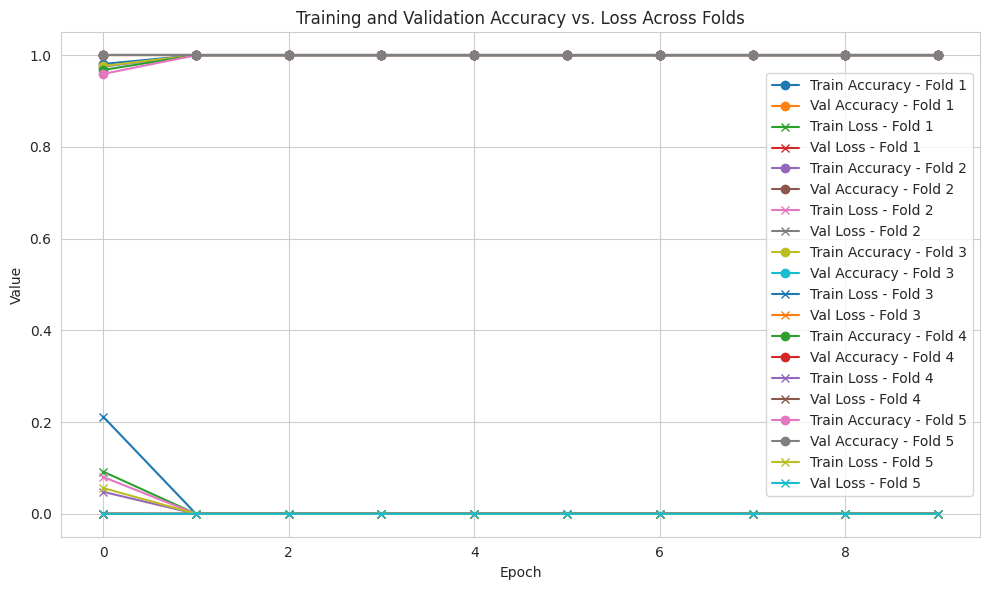

CNN cross-validated scores:
Cross-validated Accuracy: [1.0, 1.0, 1.0, 1.0, 1.0]
Mean Accuracy: 1.0
Cross-validated Precision: [1.0, 1.0, 1.0, 1.0, 1.0]
Mean Precision: 1.0
Cross-validated Recall: [1.0, 1.0, 1.0, 1.0, 1.0]
Mean Recall: 1.0
Cross-validated F1-Score: [1.0, 1.0, 1.0, 1.0, 1.0]
Mean F1-Score: 1.0


In [ ]:
warnings.filterwarnings("ignore") # Suppress warnings for cleaner output

# Define CNN model (same as before)
def create_cnn_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(2, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    return model


# Ensure y_train is in class label format (not one-hot)
if len(y_train.shape) > 1 and y_train.shape[1] > 1:
    y_train_labels = np.argmax(y_train, axis=1)  # Convert to class labels
else:
    y_train_labels = y_train  # Already class labels


# Initialize StratifiedKFold for cross-validation (5 folds, with shuffling)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

# Initialize lists to store evaluation metrics for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Create a figure to plot the training history for accuracy and loss
plt.figure(figsize=(10, 6))

# Iterate through each fold in the StratifiedKFold cross-validation
for fold, (train_index, val_index) in enumerate(kf.split(X_train, y_train_labels)):
    # Split data into training and validation sets for the current fold
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train_labels[train_index], y_train_labels[val_index]

    # One-hot encode labels for training and validation
    y_train_fold_onehot = to_categorical(y_train_fold, num_classes=2) if len(y_train_fold.shape) == 1 else y_train_fold
    y_val_fold_onehot = to_categorical(y_val_fold, num_classes=2) if len(y_val_fold.shape) == 1 else y_val_fold

    # Create and train the CNN model and Added validation_data to history
    cnn_model = create_cnn_model()
    # Train the model on the current fold's data with validation data included
    history = cnn_model.fit(X_train_fold, y_train_fold_onehot, validation_data=(X_val_fold, y_val_fold_onehot), batch_size=32, epochs=10, verbose=0) # verbose=0 for a clean output and while tracking the progress visually using plots

    # Predict the validation set results
    val_predictions = cnn_model.predict(X_val_fold)
    val_pred_classes = np.argmax(val_predictions, axis=1)
    val_true_classes = np.argmax(y_val_fold_onehot, axis=1) if len(y_val_fold_onehot.shape) > 1 else y_val_fold_onehot

    # Calculate evaluation metrics for the current fold
    accuracy_scores.append(accuracy_score(val_true_classes, val_pred_classes))
    precision_scores.append(precision_score(val_true_classes, val_pred_classes, average='binary'))
    recall_scores.append(recall_score(val_true_classes, val_pred_classes, average='binary'))
    f1_scores.append(f1_score(val_true_classes, val_pred_classes, average='binary'))

    # Convert the training history into a DataFrame for easier visualization
    losses = pd.DataFrame(history.history)

    # Plot training and validation accuracy vs. loss for each epoch (for each fold)
    plt.plot(losses.index, losses['accuracy'], label=f'Train Accuracy - Fold {fold+1}', marker='o')
    plt.plot(losses.index, losses['val_accuracy'], label=f'Val Accuracy - Fold {fold+1}', marker='o')
    plt.plot(losses.index, losses['loss'], label=f'Train Loss - Fold {fold+1}', marker='x')
    plt.plot(losses.index, losses['val_loss'], label=f'Val Loss - Fold {fold+1}', marker='x')

# Finalize and display the training history plot
plt.title('Training and Validation Accuracy vs. Loss Across Folds')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print out the cross-validation results for evaluation metrics
print('CNN cross-validated scores:')
print('Cross-validated Accuracy:', accuracy_scores)
print('Mean Accuracy:', np.mean(accuracy_scores))

print('Cross-validated Precision:', precision_scores)
print('Mean Precision:', np.mean(precision_scores))

print('Cross-validated Recall:', recall_scores)
print('Mean Recall:', np.mean(recall_scores))

print('Cross-validated F1-Score:', f1_scores)
print('Mean F1-Score:', np.mean(f1_scores))


- The CNN has also archieved perfect results like SVM.

### Which Model to Choose for the Next Experiment?

Both models archieved same results for task 1, but **Vanilla-CNN** has been chosen due to the followings:

1.   CNNs learn hierarchical features directly from image pixels, without the need for handcrafted feature extraction (like HOG).

2.   CNN allow flexibility as their architectures can be easily extended with modern deep learning techniques such as data augmentation,and transfer learning.

3.   While SVMs showed some interpretability through PCA they don't provide direct spatial insights into the image. In contrast, CNNs support tools like Grad-CAM, enabling spatial localization of important regions which will be crucial for justifying decisions.

4.   CNNs have been accelerated by the GPU in my Google Colab environment, making the usual speed advantage of SVMs less significant.





#### Loading the opening and closed heart images for experiment two and three.

In [ ]:
# Define original image dimensions (as per the dataset description)
img_width, img_height = 128, 128

# Set data directories for closed and open heart images only
base_path = '/content/drive/MyDrive/data_cw/data'
heart_closed_dir = os.path.join(base_path, 'heart/closed')
heart_open_dir = os.path.join(base_path, 'heart/open')

# Create labels: 0 = closed heart, 1 = open heart
label_map = {
    heart_closed_dir: 0,  # Closed heart images get label 0
    heart_open_dir: 1     # Open heart images get label 1
}

# Lists to store data
heart_combined_images = []  # For CNN (3D array of grayscale images)
heart_labels = []           # Labels (0 for closed, 1 for open)

# Load and process heart images
for dir_path, label in label_map.items():
    for filename in os.listdir(dir_path):
        file_path = os.path.join(dir_path, filename)
        try:
            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                raise ValueError("Image not loaded properly")
            if img.shape != (img_height, img_width):
                raise ValueError(f"Unexpected shape {img.shape} in {filename}")
            heart_combined_images.append(img)  # Add image to the combined list
            heart_labels.append(label)         # Add corresponding label
        except Exception as e:
            print(f"Error loading image {filename}: {e}")

# Convert to NumPy arrays
heart_combined_images = np.array(heart_combined_images)  # shape: (N, 128, 128)
heart_labels = np.array(heart_labels)  # shape: (N,)

# Output shape info
print("Shape of heart images array:", heart_combined_images.shape)  # Images ready for CNN (grayscale)
print("Target labels shape:", heart_labels.shape)

# Verify label counts in the combined dataset
print(f"Total Closed Heart Images (Label 0): {np.count_nonzero(heart_labels == 0)}")
print(f"Total Open Heart Images (Label 1): {np.count_nonzero(heart_labels == 1)}")


Shape of heart images array: (218, 128, 128)
Target labels shape: (218,)
Total Closed Heart Images (Label 0): 80
Total Open Heart Images (Label 1): 138


## **EXPERIMENT TWO**

### Vanilla CNN on classification of open and closed heart images.

Training set - Open Heart images: 103, Closed images: 60
Testing set - Open Heart images: 35, Open images: 20
X_train shape: (163, 128, 128, 3), y_train shape: (163, 2)
X_test shape: (55, 128, 128, 3), y_test shape: (55, 2)


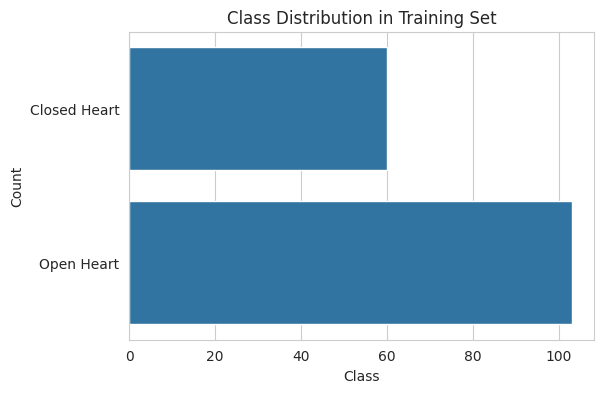

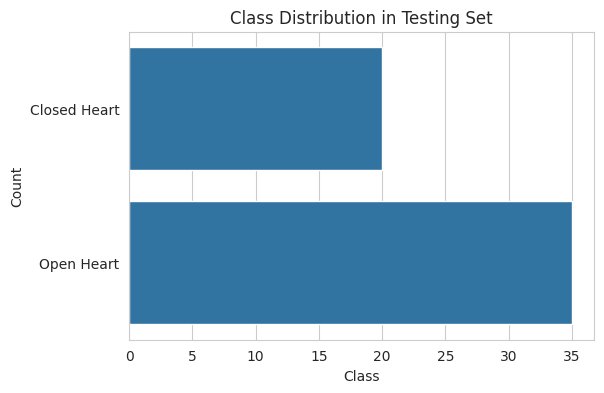

In [ ]:
# Shuffle dataset to ensure randomness
all_images, all_labels = shuffle(heart_combined_images, heart_labels, random_state=42)  # Using images and labels loaded in the previous step

# Split the dataset into training and testing sets while preserving the class distribution
X_train, X_test, y_train, y_test = train_test_split(
    all_images, all_labels, stratify=all_labels, test_size=0.25, random_state=42  # stratified 75/25 train/test
)

# Display the class distribution in the training and testing sets
print(f"Training set - Open Heart images: {np.count_nonzero(np.array(y_train) == 1)}, Closed images: {np.count_nonzero(np.array(y_train) == 0)}")
print(f"Testing set - Open Heart images: {np.count_nonzero(np.array(y_test) == 1)}, Open images: {np.count_nonzero(np.array(y_test) == 0)}")

# Convert grayscale images to RGB by repeating the single channel across 3 channels (required for CNN input)
X_train = np.repeat(X_train[..., np.newaxis], 3, axis=-1)
X_test = np.repeat(X_test[..., np.newaxis], 3, axis=-1)

# Normalize pixel values to the range [0, 1] and ensure data type is float32 (standard input format for neural networks)
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# Convert labels to categorical format for binary classification
y_train = utils.to_categorical(y_train, 2)  # 2 for binary classification
y_test = utils.to_categorical(y_test, 2)  # 2 for binary classification

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# Plot the class distribution for the training set
train_labels = ["Open Heart" if label == 1 else "Closed Heart" for label in y_train.argmax(axis=1)]
sns.set_style('whitegrid')
plt.figure(figsize=(6, 4))
sns.countplot(train_labels)
plt.title('Class Distribution in Training Set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Plot the class distribution for the testing set
test_labels = ["Open Heart" if label == 1 else "Closed Heart" for label in y_test.argmax(axis=1)]
sns.set_style('whitegrid')
plt.figure(figsize=(6, 4))
sns.countplot(test_labels)
plt.title('Class Distribution in Testing Set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

The imbalance in this dataset may lead classification models to focus more on open and struggle to accurately detect closed heart images.

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step

Fold 1: Accuracy=0.9697, Precision=0.9545, Recall=1.0000, F1=0.9767, AUC=0.9802


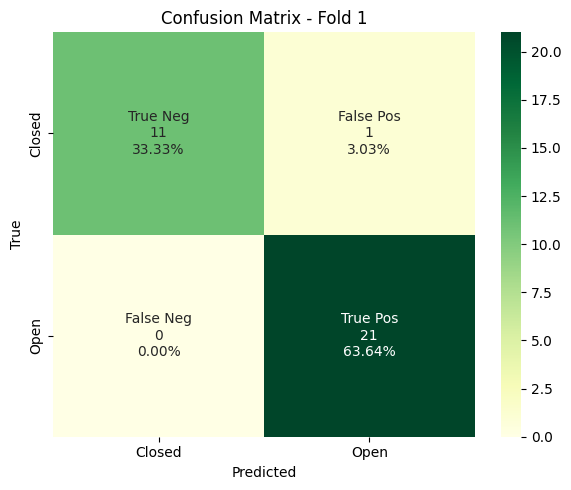

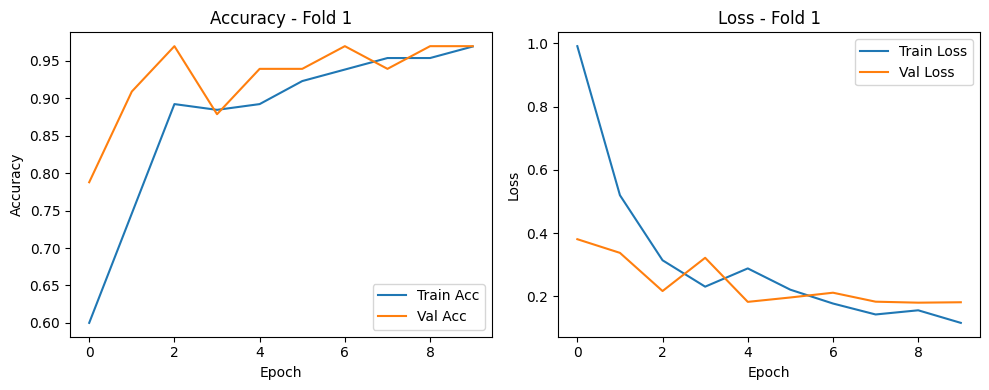

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 310ms/step

Fold 2: Accuracy=0.9394, Precision=0.9130, Recall=1.0000, F1=0.9545, AUC=0.9960


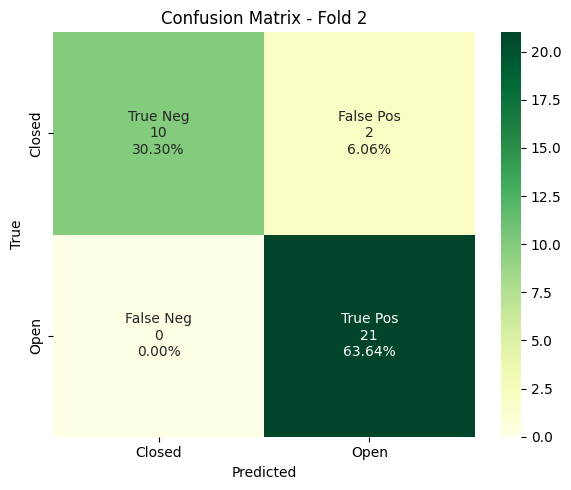

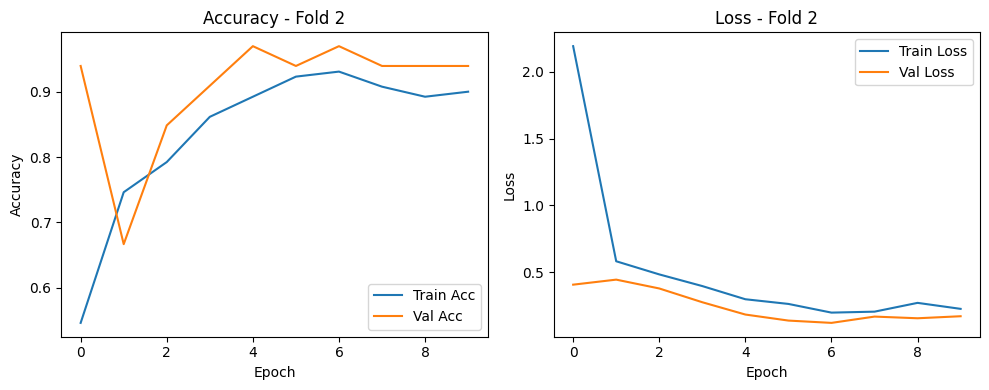

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 320ms/step

Fold 3: Accuracy=0.9394, Precision=0.9524, Recall=0.9524, F1=0.9524, AUC=0.9762


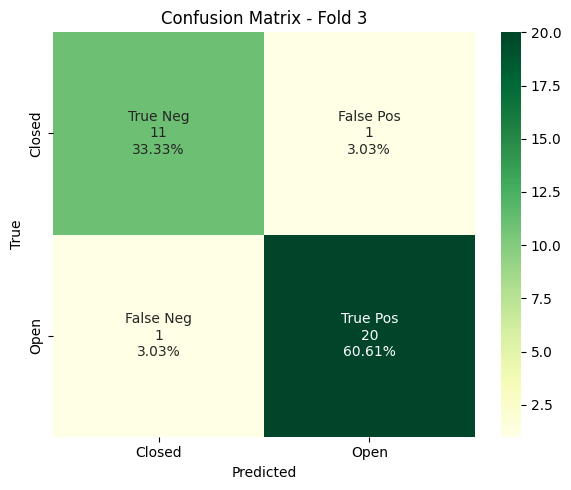

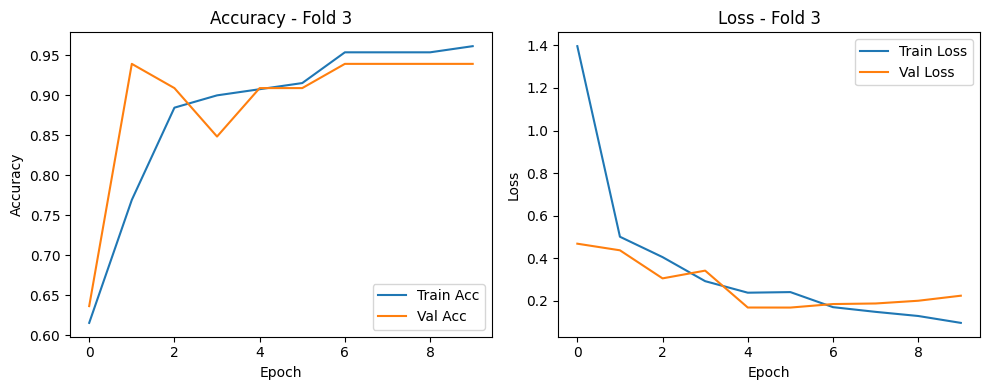

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step

Fold 4: Accuracy=0.8750, Precision=0.9000, Recall=0.9000, F1=0.9000, AUC=0.9167


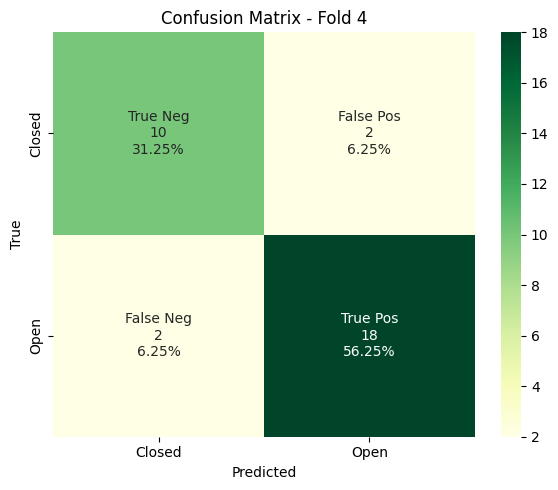

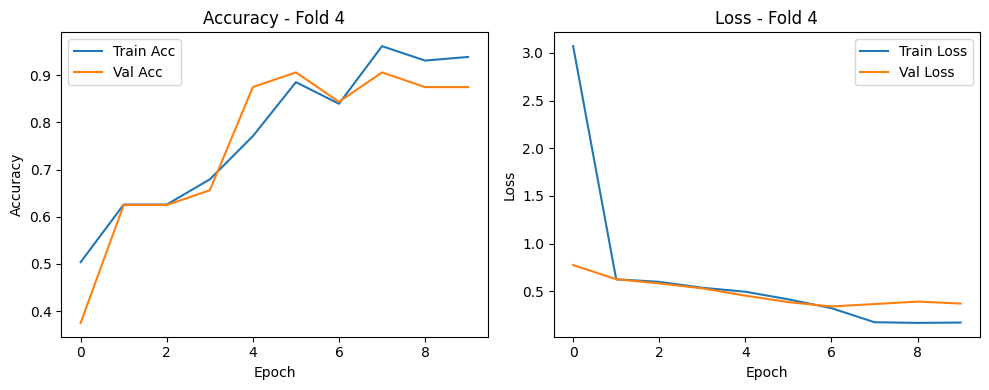

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step

Fold 5: Accuracy=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000, AUC=1.0000


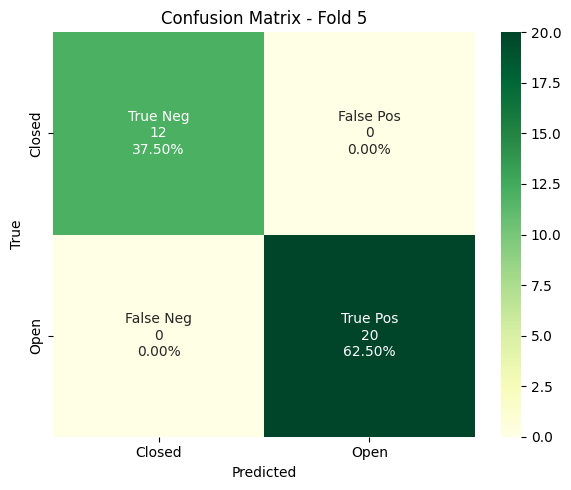

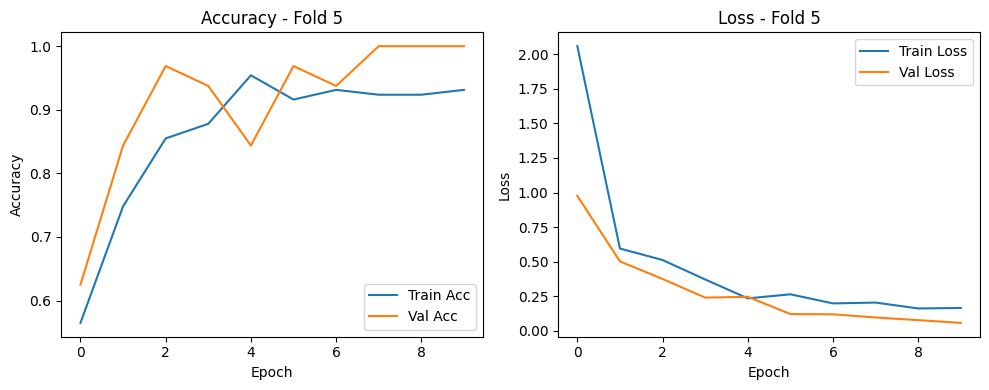


--- Cross-validated Metrics for CNN ---
Accuracy scores (by fold): [0.9696969696969697, 0.9393939393939394, 0.9393939393939394, 0.875, 1.0]
Mean Accuracy: 0.9447
Precision scores (by fold): [0.9545454545454546, 0.9130434782608695, 0.9523809523809523, 0.9, 1.0]
Mean Precision: 0.9440
Recall scores (by fold): [1.0, 1.0, 0.9523809523809523, 0.9, 1.0]
Mean Recall: 0.9705
F1 scores (by fold): [0.9767441860465116, 0.9545454545454546, 0.9523809523809523, 0.9, 1.0]
Mean F1-Score: 0.9567
Total Runtime (cross-validation): 61.04 seconds

Total Confusion Matrix (all folds combined):
[[ 54   6]
 [  3 100]]


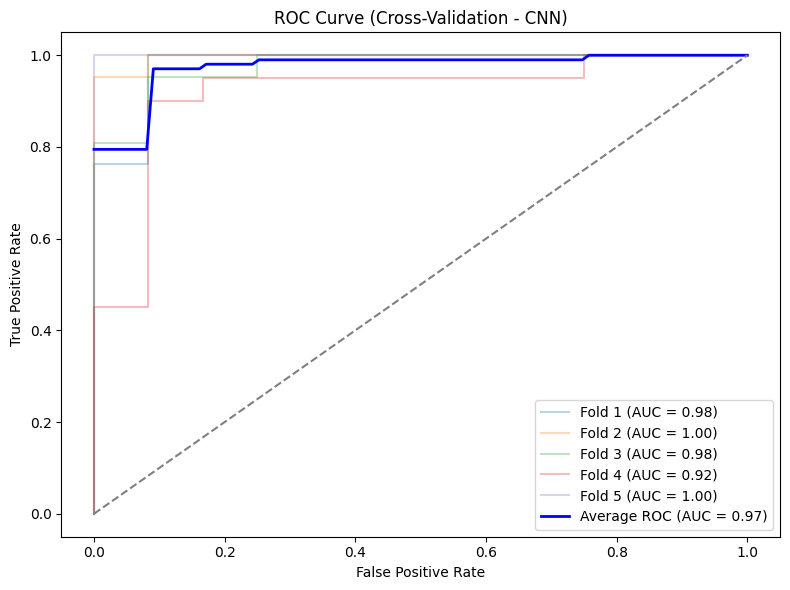

In [ ]:
# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# --- Define a simple Convolutional Neural Network model ---
def create_cnn_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),  # First convolutional layer
        Conv2D(32, (3, 3), activation='relu'),  # Second convolutional layer
        MaxPooling2D(pool_size=(2, 2)),  # Downsample with max pooling
        Dropout(0.25),  # Dropout to reduce overfitting
        Flatten(),  # Flatten feature maps into a vector
        Dense(128, activation='relu'),  # Fully connected layer
        Dropout(0.5),  # More dropout
        Dense(2, activation='softmax')  # Output layer with 2 classes (Closed/Open)
    ])
    model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    return model

# --- Prepare class labels for stratified sampling ---
# If labels are one-hot encoded, convert to class index
if len(y_train.shape) > 1 and y_train.shape[1] > 1:
    y_train_labels = np.argmax(y_train, axis=1)
else:
    y_train_labels = y_train

# --- Initialize lists to store evaluation metrics ---
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
conf_matrices = []
fpr_list = []
tpr_list = []
auc_list = []
total_runtime = 0.0

# Class label names for plotting
classes = ['Closed', 'Open']

# --- Perform 5-fold Stratified Cross-Validation ---
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train_labels), 1):
    # Split data for this fold
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train_labels[train_idx], y_train_labels[val_idx]

    # One-hot encode class labels
    y_train_fold_onehot = to_categorical(y_train_fold, num_classes=2)
    y_val_fold_onehot = to_categorical(y_val_fold, num_classes=2)

    # Build and train CNN model
    cnn_model = create_cnn_model()
    start_time = time.time()
    history = cnn_model.fit(
        X_train_fold, y_train_fold_onehot,
        validation_data=(X_val_fold, y_val_fold_onehot),
        epochs=10, batch_size=32, verbose=0
    )
    fit_time = time.time() - start_time
    total_runtime += fit_time

    # Predict probabilities and class labels
    y_val_proba = cnn_model.predict(X_val_fold)
    y_val_pred = np.argmax(y_val_proba, axis=1)
    y_val_true = y_val_fold

    # --- Calculate evaluation metrics ---
    acc = accuracy_score(y_val_true, y_val_pred)
    prec = precision_score(y_val_true, y_val_pred)
    rec = recall_score(y_val_true, y_val_pred)
    f1 = f1_score(y_val_true, y_val_pred)

    # Append metrics to lists
    accuracy_scores.append(acc)
    precision_scores.append(prec)
    recall_scores.append(rec)
    f1_scores.append(f1)

    # Confusion matrix for this fold
    cm = confusion_matrix(y_val_true, y_val_pred)
    conf_matrices.append(cm)

    # Compute ROC curve and AUC for this fold
    fpr, tpr, _ = roc_curve(y_val_true, y_val_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    auc_list.append(roc_auc)

    # --- Print metrics and confusion matrix ---
    print(f"\nFold {fold}: Accuracy={acc:.4f}, Precision={prec:.4f}, Recall={rec:.4f}, F1={f1:.4f}, AUC={roc_auc:.4f}")

    # --- Plot confusion matrix ---
    plt.figure(figsize=(6, 5))
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cm.flatten() / np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    sns.heatmap(cm, annot=labels, fmt='', cmap='YlGn', xticklabels=classes, yticklabels=classes)
    plt.title(f'Confusion Matrix - Fold {fold}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

    # --- Plot training history for accuracy and loss ---
    hist_df = pd.DataFrame(history.history)
    plt.figure(figsize=(10, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(hist_df['accuracy'], label='Train Acc')
    plt.plot(hist_df['val_accuracy'], label='Val Acc')
    plt.title(f'Accuracy - Fold {fold}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(hist_df['loss'], label='Train Loss')
    plt.plot(hist_df['val_loss'], label='Val Loss')
    plt.title(f'Loss - Fold {fold}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# --- Print average performance across all folds ---
print("\n--- Cross-validated Metrics for CNN ---")
print(f"Accuracy scores (by fold): {accuracy_scores}")
print(f"Mean Accuracy: {np.mean(accuracy_scores):.4f}")

print(f"Precision scores (by fold): {precision_scores}")
print(f"Mean Precision: {np.mean(precision_scores):.4f}")

print(f"Recall scores (by fold): {recall_scores}")
print(f"Mean Recall: {np.mean(recall_scores):.4f}")

print(f"F1 scores (by fold): {f1_scores}")
print(f"Mean F1-Score: {np.mean(f1_scores):.4f}")

print(f"Total Runtime (cross-validation): {total_runtime:.2f} seconds")

# --- Combine confusion matrices across all folds ---
total_cm = np.sum(conf_matrices, axis=0)
print(f"\nTotal Confusion Matrix (all folds combined):\n{total_cm}")

# --- Plot averaged ROC curve across folds ---
mean_fpr = np.linspace(0, 1, 100)
mean_tpr = np.mean([np.interp(mean_fpr, fpr_list[i], tpr_list[i]) for i in range(len(fpr_list))], axis=0)
mean_auc = auc(mean_fpr, mean_tpr)

plt.figure(figsize=(8, 6))
for i in range(len(fpr_list)):
    plt.plot(fpr_list[i], tpr_list[i], alpha=0.3, label=f'Fold {i+1} (AUC = {auc_list[i]:.2f})')

plt.plot(mean_fpr, mean_tpr, color='blue', lw=2, label=f'Average ROC (AUC = {mean_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

plt.title("ROC Curve (Cross-Validation - CNN)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


- The Vanilla CNN performs well overall with a relatively fast runtime of just under 1 minute, achieving high precision and accuracy. The F1-score of 95.67% strikes a solid balance, with the model even excelling in the recall metric, though slight misclassification of "Closed" heart images occurs due to class imbalance.

- The average AUC of 0.97 highlights the model's strong ability to distinguish between the two classes.

## **EXPERIMENT THREE**

### Pretrained ResNet152V2 CNN Model

While the Vanilla CNN achieved high performance, I am applying a deeper and more powerful model, ResNet152V2, to further enhance performance and improve generalization.

- - class weighting is applied to directly address the class imbalance seen in Vanilla and improve recall for the minority class.

- - Fine-tuning is also implemented to adapt the model to the specific characteristics of heart ultrasound images, which differ significantly from the natural images used to pretrain the model on the ImageNet dataset (He et al., 2016).

X_train shape: (163, 128, 128, 3), y_train shape: (163,)
X_test shape: (55, 128, 128, 3), y_test shape: (55,)
234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 23s 11s/step

Fold 1: Accuracy=0.9394, Precision=0.9130, Recall=1.0000, F1=0.9545, AUC=0.9206


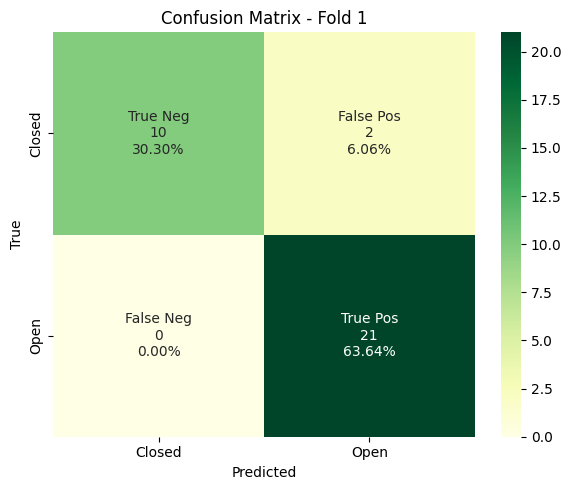

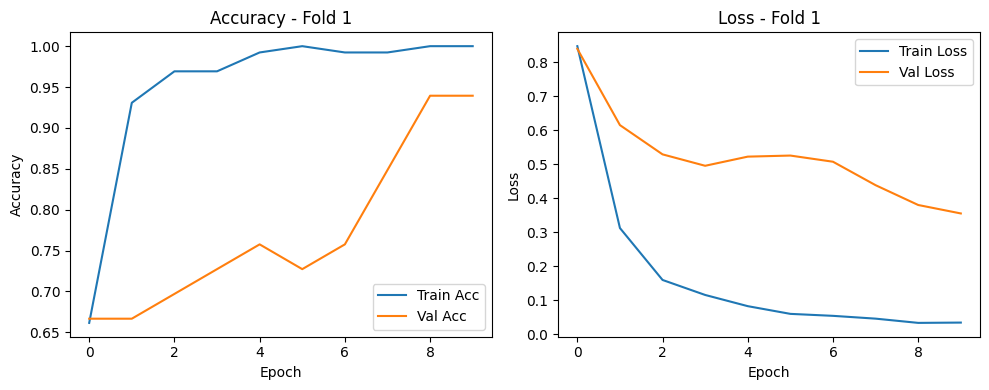

2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 10s/step

Fold 2: Accuracy=0.9394, Precision=0.9524, Recall=0.9524, F1=0.9524, AUC=0.9841


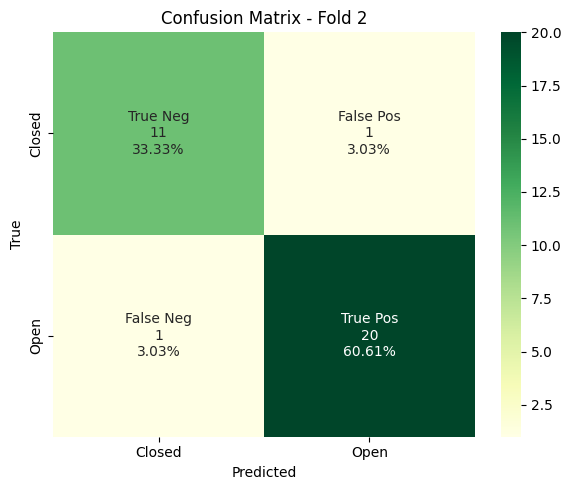

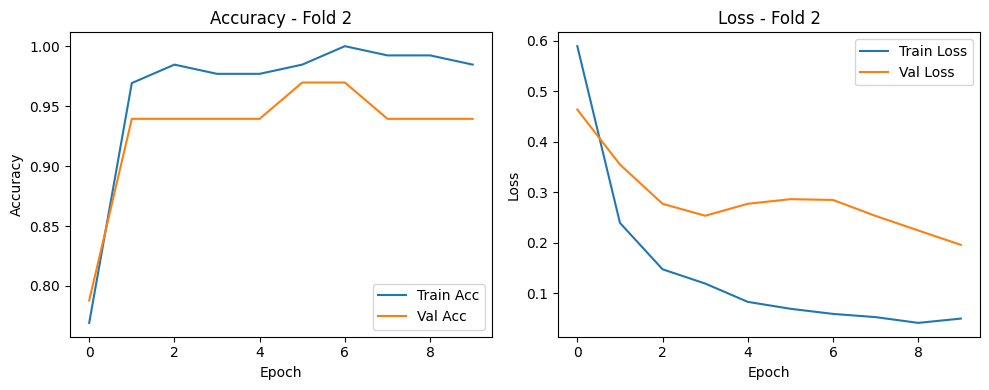

2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 10s/step

Fold 3: Accuracy=0.9697, Precision=1.0000, Recall=0.9524, F1=0.9756, AUC=0.9841


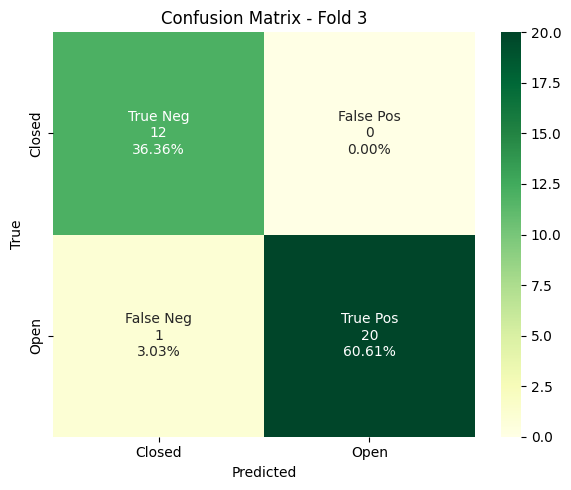

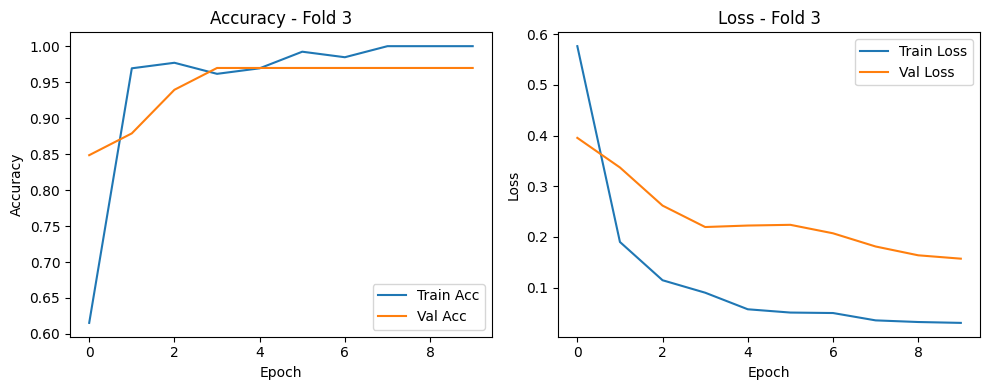

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step

Fold 4: Accuracy=0.9062, Precision=0.9474, Recall=0.9000, F1=0.9231, AUC=0.9833


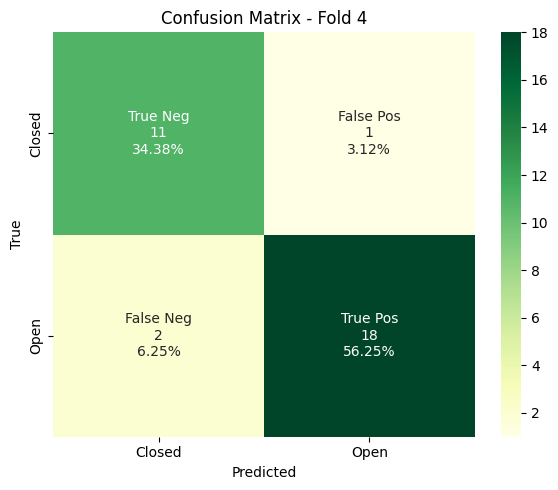

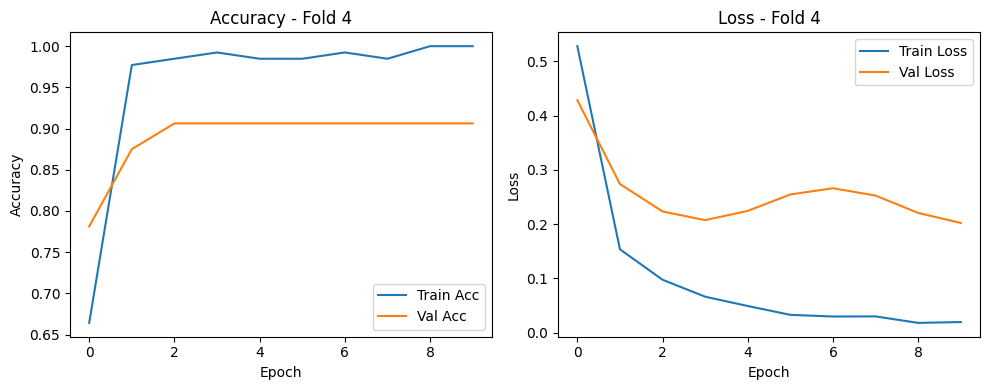

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step

Fold 5: Accuracy=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000, AUC=1.0000


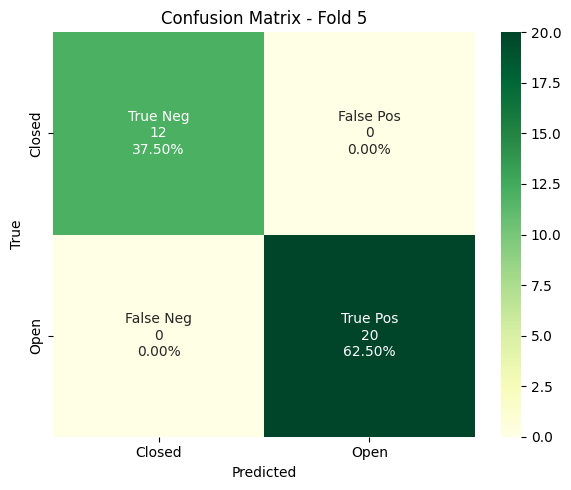

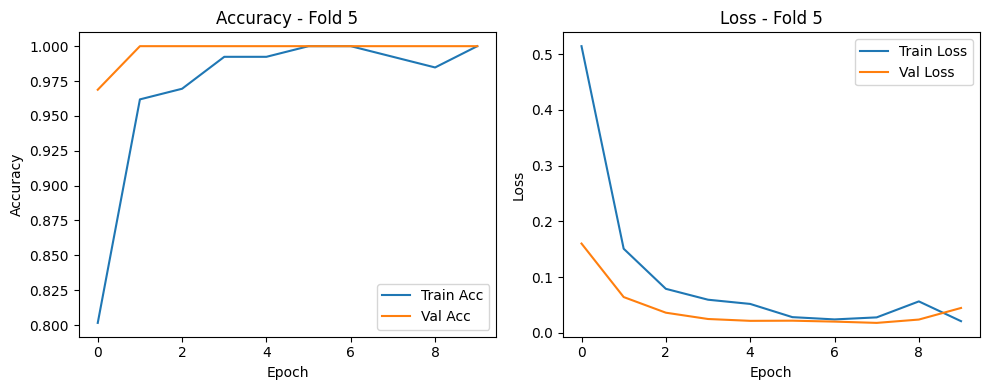


--- Cross-validated Metrics for ResNet152V2 ---
Accuracy: [0.9393939393939394, 0.9393939393939394, 0.9696969696969697, 0.90625, 1.0], Mean: 0.9509
Precision: [0.9130434782608695, 0.9523809523809523, 1.0, 0.9473684210526315, 1.0], Mean: 0.9626
Recall: [1.0, 0.9523809523809523, 0.9523809523809523, 0.9, 1.0], Mean: 0.9610
F1 Score: [0.9545454545454546, 0.9523809523809523, 0.975609756097561, 0.9230769230769231, 1.0], Mean: 0.9611
Total Runtime: 311.43 seconds

Total Confusion Matrix:
[[56  4]
 [ 4 99]]


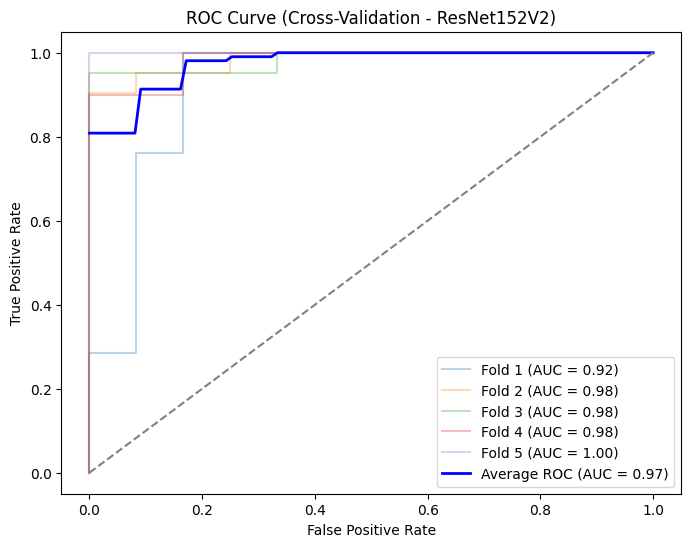

In [ ]:
# =====================================================================================
# ============================ IMAGE LOADING & PREPROCESSING ==========================
# =====================================================================================
# Suppress any warning messages
warnings.filterwarnings("ignore")

# --- Data Preprocessing ---
# Shuffle and split the data into training and test sets
all_images, all_labels = shuffle(heart_combined_images, heart_labels, random_state=42)

# Split the data with stratification to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    all_images, all_labels, stratify=all_labels, test_size=0.25, random_state=42
)

# Expand grayscale to 3 channels and normalize pixel values to [0, 1]
X_train = np.repeat(X_train[..., np.newaxis], 3, axis=-1).astype('float32') / 255
X_test = np.repeat(X_test[..., np.newaxis], 3, axis=-1).astype('float32') / 255

# Display dataset shapes
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# --- Load and Prepare Pretrained ResNet152V2 ---
img_size = 128
tf.keras.backend.clear_session()  # Clear previous sessions to avoid clutter




# =======================================================================================
# ============================ MODEL INITIALIZATION(WITH FINE-TUNING) & CLASSIFICATION ==
# =======================================================================================
# Load ResNet152V2 without top layers and freeze base layers
base_model = tf.keras.applications.ResNet152V2(
    weights='imagenet',
    input_shape=(img_size, img_size, 3),
    include_top=False
)
base_model.trainable = False  # Freeze all layers initially

# Function to build the classifier using pretrained base
def get_pretrained():
    inputs = layers.Input(shape=(img_size, img_size, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    output = layers.Dense(2, activation='softmax')(x)
    return Model(inputs, output)

# Unfreeze the last few layers for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-10]:
    layer.trainable = False




# =====================================================================================
# ============================ CROSS-VALIDATION & EVALUATION ==========================
# =====================================================================================
# --- Initialize Cross-Validation ---
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracy_scores, precision_scores, recall_scores, f1_scores = [], [], [], []
conf_matrices, fpr_list, tpr_list, auc_list = [], [], [], []
total_runtime = 0.0
classes = ['Closed', 'Open']

# --- 5-Fold Cross-Validation Loop ---
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train), 1):
    # Split training and validation data for this fold
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

    # One-hot encode the labels
    y_train_fold_cat = to_categorical(y_train_fold, 2)
    y_val_fold_cat = to_categorical(y_val_fold, 2)

    # Compute class weights to handle class imbalance
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train_fold),
        y=y_train_fold
    )
    class_weight_dict = dict(enumerate(class_weights))

    # Build and compile the model
    model = get_pretrained()
    model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
        metrics=['accuracy']
    )

    # Train the model and record training time
    start_time = time.time()
    history = model.fit(
        X_train_fold, y_train_fold_cat,
        validation_data=(X_val_fold, y_val_fold_cat),
        epochs=10,
        batch_size=32,
        verbose=0,
        class_weight=class_weight_dict
    )
    fit_time = time.time() - start_time
    total_runtime += fit_time

    # Predict and evaluate
    y_val_proba = model.predict(X_val_fold)
    y_val_pred = np.argmax(y_val_proba, axis=1)
    y_val_true = np.argmax(y_val_fold_cat, axis=1)

    # Compute metrics
    acc = accuracy_score(y_val_true, y_val_pred)
    prec = precision_score(y_val_true, y_val_pred)
    rec = recall_score(y_val_true, y_val_pred)
    f1 = f1_score(y_val_true, y_val_pred)

    # Save metrics
    accuracy_scores.append(acc)
    precision_scores.append(prec)
    recall_scores.append(rec)
    f1_scores.append(f1)

    # Confusion matrix and ROC curve
    cm = confusion_matrix(y_val_true, y_val_pred)
    conf_matrices.append(cm)

    fpr, tpr, _ = roc_curve(y_val_true, y_val_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    auc_list.append(roc_auc)

    # Display fold results
    print(f"\nFold {fold}: Accuracy={acc:.4f}, Precision={prec:.4f}, Recall={rec:.4f}, F1={f1:.4f}, AUC={roc_auc:.4f}")

    # --- Plot Confusion Matrix ---
    plt.figure(figsize=(6, 5))
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cm.flatten() / np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(cm, annot=labels, fmt='', cmap='YlGn', xticklabels=classes, yticklabels=classes)
    plt.title(f'Confusion Matrix - Fold {fold}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

    # --- Plot Accuracy and Loss ---
    hist_df = pd.DataFrame(history.history)
    plt.figure(figsize=(10, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(hist_df['accuracy'], label='Train Acc')
    plt.plot(hist_df['val_accuracy'], label='Val Acc')
    plt.title(f'Accuracy - Fold {fold}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(hist_df['loss'], label='Train Loss')
    plt.plot(hist_df['val_loss'], label='Val Loss')
    plt.title(f'Loss - Fold {fold}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# --- Summary of Cross-Validation Results ---
print("\n--- Cross-validated Metrics for ResNet152V2 ---")
print(f"Accuracy: {accuracy_scores}, Mean: {np.mean(accuracy_scores):.4f}")
print(f"Precision: {precision_scores}, Mean: {np.mean(precision_scores):.4f}")
print(f"Recall: {recall_scores}, Mean: {np.mean(recall_scores):.4f}")
print(f"F1 Score: {f1_scores}, Mean: {np.mean(f1_scores):.4f}")
print(f"Total Runtime: {total_runtime:.2f} seconds")

# --- Combined Confusion Matrix Across All Folds ---
total_cm = np.sum(conf_matrices, axis=0)
print(f"\nTotal Confusion Matrix:\n{total_cm}")

# --- Plot Average ROC Curve ---
mean_fpr = np.linspace(0, 1, 100)
mean_tpr = np.mean([np.interp(mean_fpr, fpr_list[i], tpr_list[i]) for i in range(len(fpr_list))], axis=0)
mean_auc = auc(mean_fpr, mean_tpr)

plt.figure(figsize=(8, 6))
for i in range(len(fpr_list)):
    plt.plot(fpr_list[i], tpr_list[i], alpha=0.3, label=f'Fold {i+1} (AUC = {auc_list[i]:.2f})')

plt.plot(mean_fpr, mean_tpr, color='blue', lw=2, label=f'Average ROC (AUC = {mean_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve (Cross-Validation - ResNet152V2)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.show()


- ResNet has shown a similar ability to distinguish classes as Vanilla CNN, with an average AUC of 97%. Based on the results, ResNet152V2 generally outperforms the Vanilla CNN in accuracy, precision, and F1-score. However, recall slightly decreased, and Vanilla CNN was five times faster in training and evaluation. The confusion matrix shows improved performance by capturing two more correct minority class predictions.

###  U-Net Segmentation Model

Although ResNet152V2 achieved high performance on raw heart ultrasound images, training it using segmented images aligns more closely with the medically relevant features that clinicians rely on for diagnosis.(Orlando et al., 2021)

Asssessing the masks from Various sub-folder of heart Images folder

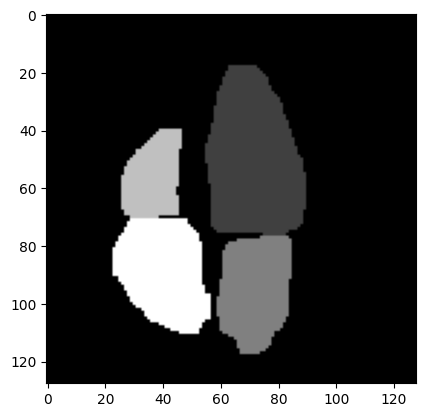

Min pixel value: 0
Max pixel value: 255
(128, 128, 3)


numpy.ndarray

In [ ]:
#Load an image from the 'closed' folder
various_masks_dir = '/content/drive/MyDrive/data_cw/data/heart/various/masks/2.tiff'
various_masks_image = cv2.imread(various_masks_dir)

# Display the image
plt.imshow(cv2.cvtColor(various_masks_image, cv2.COLOR_BGR2RGB))
plt.show()

#check the image of shape
print("Min pixel value:", various_masks_image.min())
print("Max pixel value:", various_masks_image.max())
#check the shape structure
print(various_masks_image.shape)
#check the type if is standard for processing
type(various_masks_image)

#### Training the U-Net Segmentation using the annotated masks

- Only 50% of the combined open and closed heart images, along with their corresponding annotated masks, will be used to train the U-Net segmentation model.

- The remaining images will be kept unseen during training and will be segmented later using the trained U-Net.

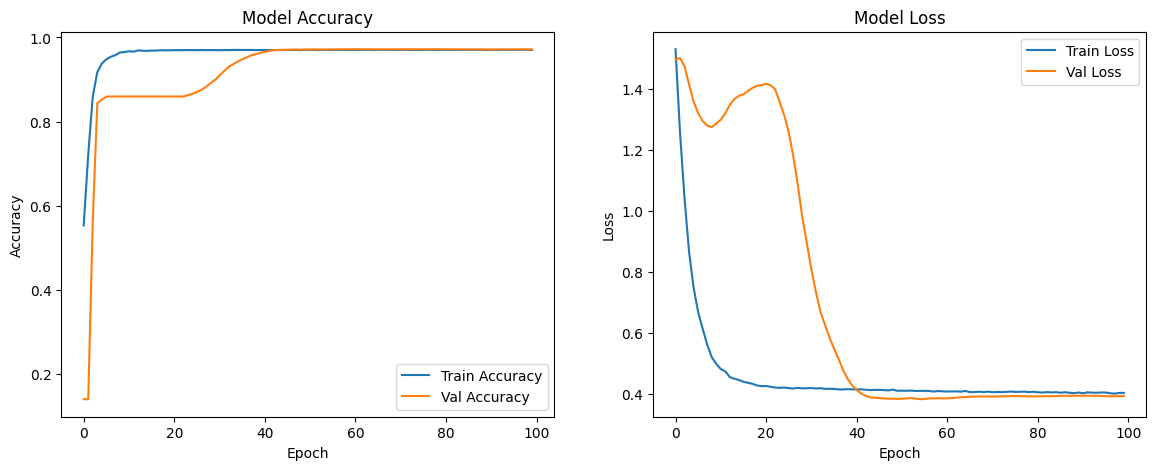

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


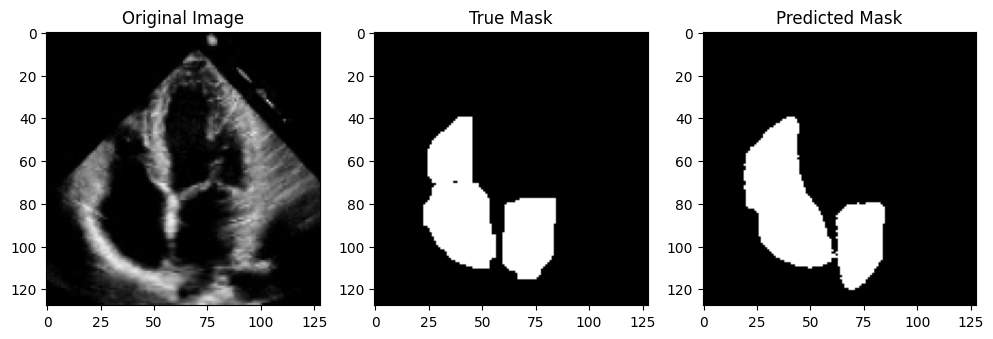


=== Segmenting Remaining Heart Images ===


Segmenting:   0%|          | 0/109 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Segmenting:   1%|          | 1/109 [00:00<00:16,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Segmenting:   2%|▏         | 2/109 [00:00<00:14,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Segmenting:   3%|▎         | 3/109 [00:00<00:13,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Segmenting:   4%|▎         | 4/109 [00:00<00:13,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Segmenting:   5%|▍         | 5/109 [00:00<00:14,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Segmenting:   6%|▌         | 6/109 [00:00<00:13,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Segmenting:   6%|▋         | 7/109 [00:00<00:12,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Segmenting:   7%|▋         | 8/109 [00:01<00:12,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Segmenting:   8%|▊         | 9/109 [00:01<00:11,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Segmenting:   9%|▉         | 10/109 [00:01<00:11,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Segmenting:  10%|█         | 11/109 [00:01<00:12,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Segmenting:  11%|█         | 12/109 [00:01<00:12,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Segmenting:  12%|█▏        | 13/109 [00:01<00:12,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Segmenting:  13%|█▎        | 14/109 [00:01<00:12,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Segmenting:  14%|█▍        | 15/109 [00:01<00:12,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Segmenting:  15%|█▍        | 16/109 [00:02<00:11,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Segmenting:  16%|█▌        | 17/109 [00:02<00:11,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Segmenting:  17%|█▋        | 18/109 [00:02<00:10,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Segmenting:  18%|█▊        | 20/109 [00:02<00:09,  9.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Segmenting:  19%|█▉        | 21/109 [00:02<00:09,  9.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Segmenting:  21%|██        | 23/109 [00:02<00:08, 10.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Segmenting:  23%|██▎       | 25/109 [00:02<00:08, 10.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Segmenting:  25%|██▍       | 27/109 [00:03<00:07, 10.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Segmenting:  27%|██▋       | 29/109 [00:03<00:07, 10.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Segmenting:  28%|██▊       | 31/109 [00:03<00:07,  9.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Segmenting:  29%|██▉       | 32/109 [00:03<00:07,  9.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Segmenting:  30%|███       | 33/109 [00:03<00:07,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Segmenting:  31%|███       | 34/109 [00:03<00:07,  9.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Segmenting:  32%|███▏      | 35/109 [00:03<00:07,  9.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Segmenting:  33%|███▎      | 36/109 [00:04<00:07,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Segmenting:  34%|███▍      | 37/109 [00:04<00:07,  9.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Segmenting:  35%|███▍      | 38/109 [00:04<00:07,  9.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Segmenting:  37%|███▋      | 40/109 [00:04<00:07,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Segmenting:  39%|███▊      | 42/109 [00:04<00:06,  9.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Segmenting:  40%|████      | 44/109 [00:04<00:06, 10.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Segmenting:  42%|████▏     | 46/109 [00:05<00:06, 10.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Segmenting:  44%|████▍     | 48/109 [00:05<00:06, 10.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Segmenting:  46%|████▌     | 50/109 [00:05<00:05, 10.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Segmenting:  48%|████▊     | 52/109 [00:05<00:05, 10.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Segmenting:  50%|████▉     | 54/109 [00:05<00:05,  9.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Segmenting:  50%|█████     | 55/109 [00:05<00:05,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Segmenting:  51%|█████▏    | 56/109 [00:06<00:05,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Segmenting:  53%|█████▎    | 58/109 [00:06<00:04, 10.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Segmenting:  55%|█████▌    | 60/109 [00:06<00:04, 10.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Segmenting:  57%|█████▋    | 62/109 [00:06<00:04,  9.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Segmenting:  59%|█████▊    | 64/109 [00:06<00:04,  9.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Segmenting:  60%|█████▉    | 65/109 [00:06<00:04,  9.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Segmenting:  61%|██████    | 66/109 [00:07<00:04,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Segmenting:  61%|██████▏   | 67/109 [00:07<00:04,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Segmenting:  63%|██████▎   | 69/109 [00:07<00:04,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Segmenting:  64%|██████▍   | 70/109 [00:07<00:04,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Segmenting:  65%|██████▌   | 71/109 [00:07<00:04,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Segmenting:  66%|██████▌   | 72/109 [00:07<00:03,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Segmenting:  68%|██████▊   | 74/109 [00:07<00:03, 10.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Segmenting:  69%|██████▉   | 75/109 [00:08<00:03,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Segmenting:  71%|███████   | 77/109 [00:08<00:03,  9.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Segmenting:  72%|███████▏  | 78/109 [00:08<00:03,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Segmenting:  73%|███████▎  | 80/109 [00:08<00:02,  9.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Segmenting:  75%|███████▌  | 82/109 [00:08<00:02, 10.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Segmenting:  77%|███████▋  | 84/109 [00:08<00:02,  9.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Segmenting:  79%|███████▉  | 86/109 [00:09<00:02,  9.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Segmenting:  80%|███████▉  | 87/109 [00:09<00:02,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Segmenting:  82%|████████▏ | 89/109 [00:09<00:01, 10.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Segmenting:  83%|████████▎ | 91/109 [00:09<00:01, 10.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Segmenting:  85%|████████▌ | 93/109 [00:09<00:01, 10.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Segmenting:  87%|████████▋ | 95/109 [00:10<00:01,  9.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Segmenting:  88%|████████▊ | 96/109 [00:10<00:01,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Segmenting:  89%|████████▉ | 97/109 [00:10<00:01,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Segmenting:  90%|████████▉ | 98/109 [00:10<00:01,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Segmenting:  91%|█████████ | 99/109 [00:10<00:01,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Segmenting:  92%|█████████▏| 100/109 [00:10<00:01,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Segmenting:  93%|█████████▎| 101/109 [00:10<00:01,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Segmenting:  94%|█████████▎| 102/109 [00:11<00:00,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Segmenting:  94%|█████████▍| 103/109 [00:11<00:00,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Segmenting:  95%|█████████▌| 104/109 [00:11<00:00,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Segmenting:  96%|█████████▋| 105/109 [00:11<00:00,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Segmenting:  97%|█████████▋| 106/109 [00:11<00:00,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Segmenting:  98%|█████████▊| 107/109 [00:11<00:00,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Segmenting:  99%|█████████▉| 108/109 [00:11<00:00,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Segmenting: 100%|██████████| 109/109 [00:12<00:00,  8.99it/s]


In [ ]:
np.random.seed(123)  # Set the seed for reproducibility
warnings.filterwarnings("ignore") # Suppress warnings to keep the output clean and focused




# ============================ LOSS FUNCTIONS ============================
# Dice loss has been used to handle imbalanced classes for image segmentation tasks.
# It also calculates the similarity between the predicted and true masks.
def dice_loss(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + 1) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1)

# The combined Dice loss with Binary Cross-Entropy (BCE) to ensure accurate segmentation loss helps to penalize false negatives and false positives in segmentation.
def dice_bce_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    return dice_loss(y_true, y_pred) + bce






# ============================ DATA LOADING ============================
# This function loads and preprocesses images and their corresponding masks.
def load_data(image_paths, mask_paths, img_size=(128, 128)):
    images, masks = [], []
    for img_path, mask_path in zip(image_paths, mask_paths):
        image = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if image is None or mask is None:
            continue

        image = cv2.resize(image, img_size) / 255.0  # Normalize image to [0, 1]
        mask = cv2.resize(mask, img_size, interpolation=cv2.INTER_NEAREST)  # Resize mask
        mask = (mask > 127).astype(np.uint8)  # Convert mask to binary
        mask = np.expand_dims(mask, axis=-1)  # Add channel dimension for mask

        images.append(image)
        masks.append(mask)

    return np.array(images), np.array(masks)






# ============================ MODEL DEFINITION ============================
# --- U-Net Model ---
# A basic U-Net model with encoding-decoding blocks for semantic segmentation tasks.
# The model uses convolutional layers, max pooling, and transpose convolution for upsampling.
def unet_model(input_size=(128, 128, 3)):
    inputs = layers.Input(input_size)

    def conv_block(x, filters):
        x = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        return x

 # Up-sampling block to increase spatial resolution.
    def up_block(x, skip, filters):
        x = layers.Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(x)
        x = layers.concatenate([x, skip])  # Skip connection from encoder
        x = conv_block(x, filters)
        return x

    c1 = conv_block(inputs, 64)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = conv_block(p1, 128)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = conv_block(p2, 256)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = conv_block(p3, 512)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    c5 = conv_block(p4, 1024)

    c6 = up_block(c5, c4, 512)
    c7 = up_block(c6, c3, 256)
    c8 = up_block(c7, c2, 128)
    c9 = up_block(c8, c1, 64)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = models.Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss=dice_bce_loss, metrics=['accuracy'])

    return model






# ============================ DATA AUGMENTATION ============================
# Data augmentation to artificially expand the dataset by applying random transformations to the images.
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)





# ===============================================================================================
# ============================ PATHS & SPLITTING ================================================
# ===============================================================================================
# Paths to the images and corresponding masks in the dataset.
heart_closed_dir = '/content/drive/MyDrive/data_cw/data/heart/closed'
heart_open_dir = '/content/drive/MyDrive/data_cw/data/heart/open'
mask_dir = '/content/drive/MyDrive/data_cw/data/heart/various/masks'

heart_closed_images = sorted([os.path.join(heart_closed_dir, img) for img in os.listdir(heart_closed_dir) if img.endswith('.jpg')])
heart_open_images = sorted([os.path.join(heart_open_dir, img) for img in os.listdir(heart_open_dir) if img.endswith('.jpg')])
mask_filenames = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith('.tiff')])

assert len(heart_closed_images) + len(heart_open_images) == len(mask_filenames), "Mismatch between images and masks!"

# --- Select only 50% from Each Class for Training the Model---
num_open_images = len(heart_open_images)
num_closed_images = len(heart_closed_images)

num_train_open = int(num_open_images * 0.5)
num_train_closed = int(num_closed_images * 0.5)

selected_open_images = heart_open_images[:num_train_open]
selected_closed_images = heart_closed_images[:num_train_closed]
selected_images = selected_open_images + selected_closed_images
selected_mask_filenames = mask_filenames[:num_train_open + num_train_closed]

# --- Load Data ---
images, masks = load_data(selected_images, selected_mask_filenames)

# --- Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.25, random_state=42)






# ===============================================================================================
# ============================ MODEL TRAINING ===================================================
# ===============================================================================================
# Train the model with data augmentation and validation.
model = unet_model()
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

history = model.fit(datagen.flow(X_train, y_train, batch_size=8),
                    validation_data=(X_test, y_test),
                    epochs=100,
                    callbacks=[lr_scheduler],
                    verbose=0)

# --- Plot Accuracy and Loss ---
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


# --- Test-Time Augmentation (TTA) ---
sample_idx = 10
sample_image = X_test[sample_idx]

# Perform TTA (flip + original)
tta_images = [sample_image, np.fliplr(sample_image)]
tta_preds = [model.predict(np.expand_dims(img, axis=0)) for img in tta_images]
tta_preds = np.mean(tta_preds, axis=0)  # Averaging predictions

predicted_mask = (tta_preds.squeeze() > 0.5).astype(np.uint8)

# Visualization
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(sample_image)
plt.title("Original Image")

plt.subplot(1, 3, 2)
plt.imshow(y_test[sample_idx].squeeze(), cmap='gray')
plt.title("True Mask")

plt.subplot(1, 3, 3)
plt.imshow(predicted_mask, cmap='gray')
plt.title("Predicted Mask")

plt.show()

# ===============================================================================================
# ============================ SAVE SEGMENTATIONS ===============================================
# ===============================================================================================
# Save the segmented images into a folder to be used in Pretrained ResNet152V2 CNN Model.

# ============================ SEGMENT REMAINING 50% IMAGES ============================
# The remaining 50% of heart ultrasound images (not seen during training) are segmented using the trained U-Net model.
remaining_open_images = heart_open_images[num_train_open:]
remaining_closed_images = heart_closed_images[num_train_closed:]

remaining_images = remaining_open_images + remaining_closed_images

segmented_dir_combined = './segmented_data_combined'
os.makedirs(segmented_dir_combined, exist_ok=True)

segmented_images = []
labels = {}

print("\n=== Segmenting Remaining Heart Images ===")

# Segment the remaining 50% images
for i, img_path in tqdm(enumerate(remaining_images), total=len(remaining_images), desc="Segmenting"):
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) if img.ndim == 3 else cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    img_resized = cv2.resize(img_rgb, (128, 128)) / 255.0
    img_input = np.expand_dims(img_resized, axis=0)

    pred_mask = model.predict(img_input)[0]
    pred_mask = (pred_mask > 0.5).astype(np.uint8) * 255

    img_mask = array_to_img(pred_mask)
    label = 'closed' if img_path in heart_closed_images else 'open'
    save_path = os.path.join(segmented_dir_combined, f"{label}_{i}.png")
    img_mask.save(save_path)

    segmented_images.append(pred_mask)
    labels[i] = label


- The training and validation accuracy curves for the U-Net model show good convergence, indicating effective learning. Similarly, the loss curves steadily decrease and stabilize, and the predicted segmentation mask closely resemble the ground truth, demonstrating the model’s reliable performance.

- These newly generated masks will then be used for the subsequent classification task.


 Total Segmented Images: 109
 Class Distribution: {np.int64(0): np.int64(40), np.int64(1): np.int64(69)} (0=closed, 1=open)

 Split Summary:
Training set size: 81
Test set size: 28
234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
Fold 1: Accuracy=0.7059, Precision=0.6875, Recall=1.0000, F1=0.8148, AUC=0.8636


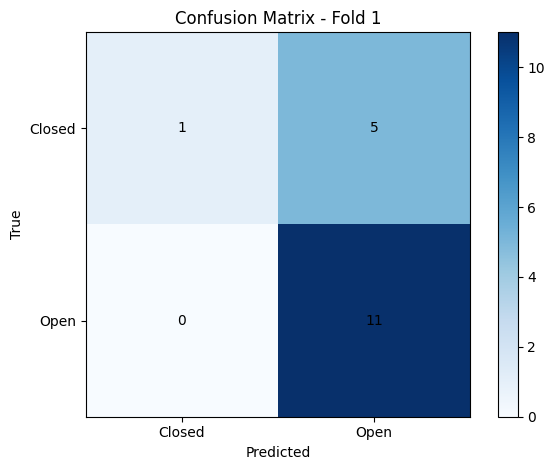

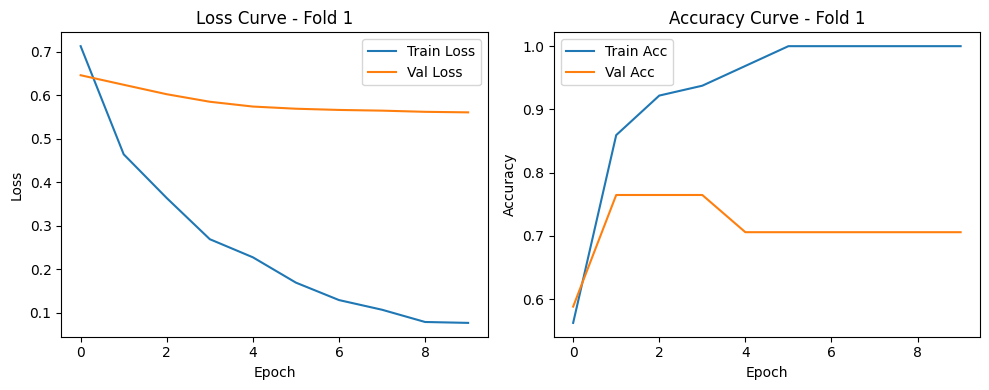

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Fold 2: Accuracy=0.5625, Precision=0.6667, Recall=0.6000, F1=0.6316, AUC=0.7667


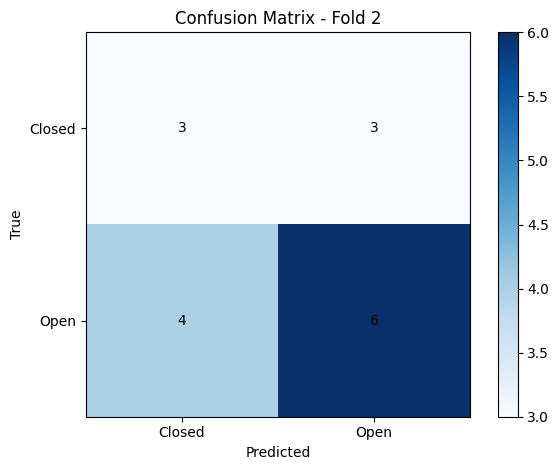

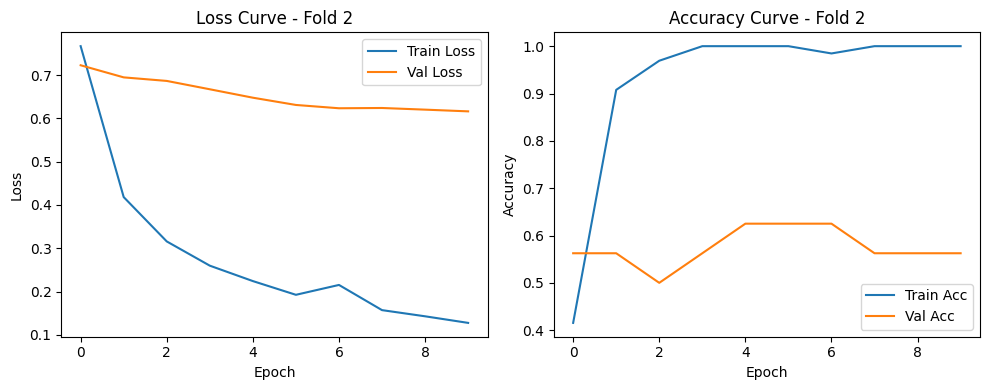

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Fold 3: Accuracy=0.6250, Precision=0.6429, Recall=0.9000, F1=0.7500, AUC=0.8000


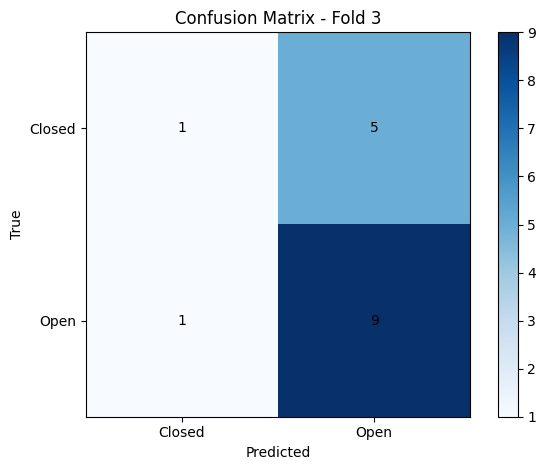

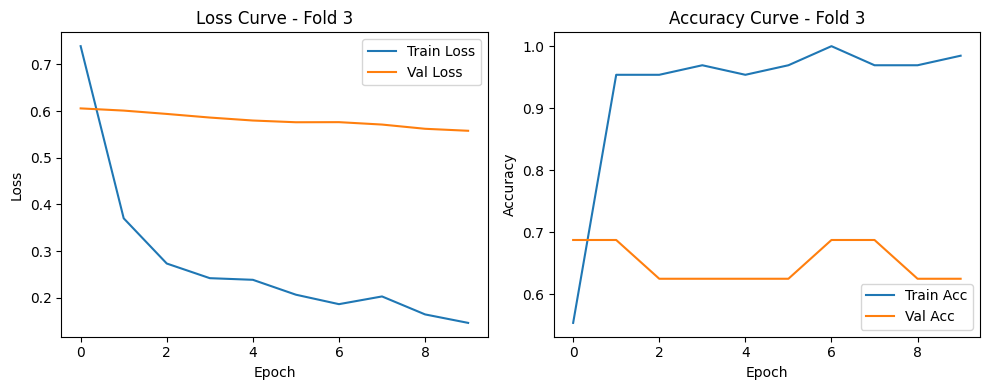

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Fold 4: Accuracy=0.6875, Precision=0.7273, Recall=0.8000, F1=0.7619, AUC=0.8667


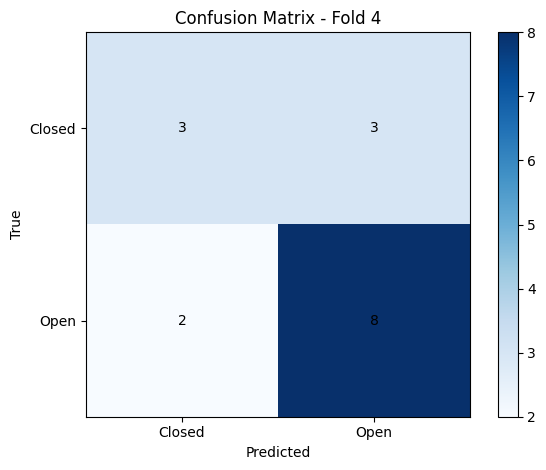

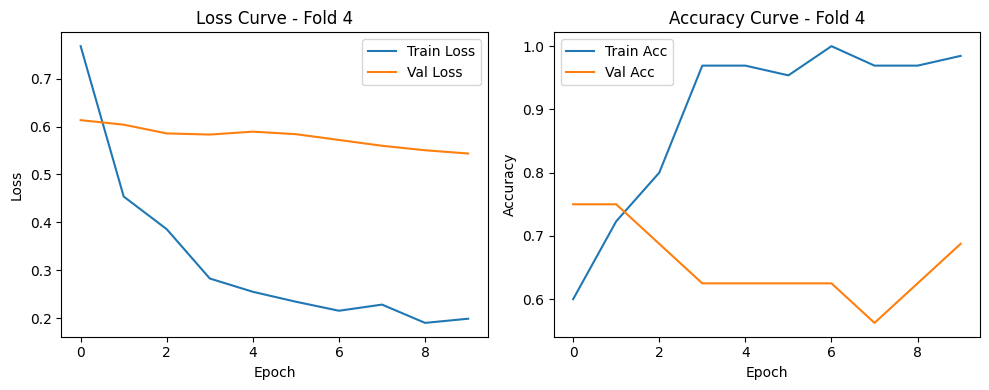

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Fold 5: Accuracy=0.6875, Precision=0.7778, Recall=0.7000, F1=0.7368, AUC=0.7167


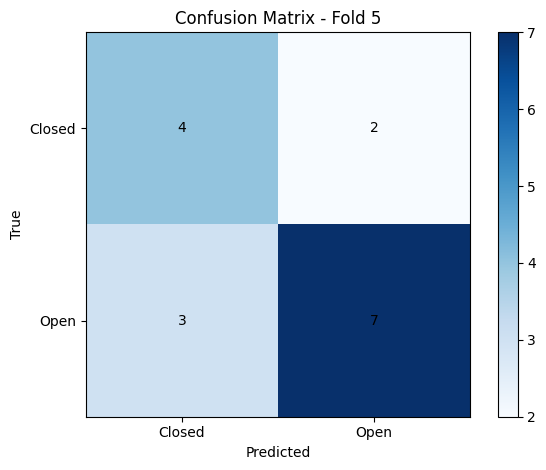

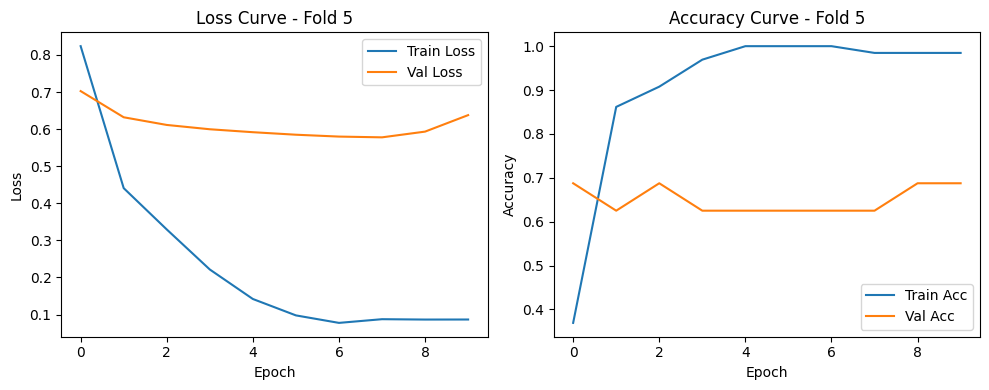


--- Cross-validated Metrics for ResNet152V2 ---
Accuracy scores (by fold): [0.7058823529411765, 0.5625, 0.625, 0.6875, 0.6875]
Mean Accuracy: 0.6537
Precision scores (by fold): [0.6875, 0.6666666666666666, 0.6428571428571429, 0.7272727272727273, 0.7777777777777778]
Mean Precision: 0.7004
Recall scores (by fold): [1.0, 0.6, 0.9, 0.8, 0.7]
Mean Recall: 0.8000
F1 scores (by fold): [0.8148148148148148, 0.631578947368421, 0.75, 0.7619047619047619, 0.7368421052631579]
Mean F1-Score: 0.7390
Total Runtime (cross-validation): 298.93 seconds

Total Confusion Matrix (all folds combined):
[[12 18]
 [10 41]]


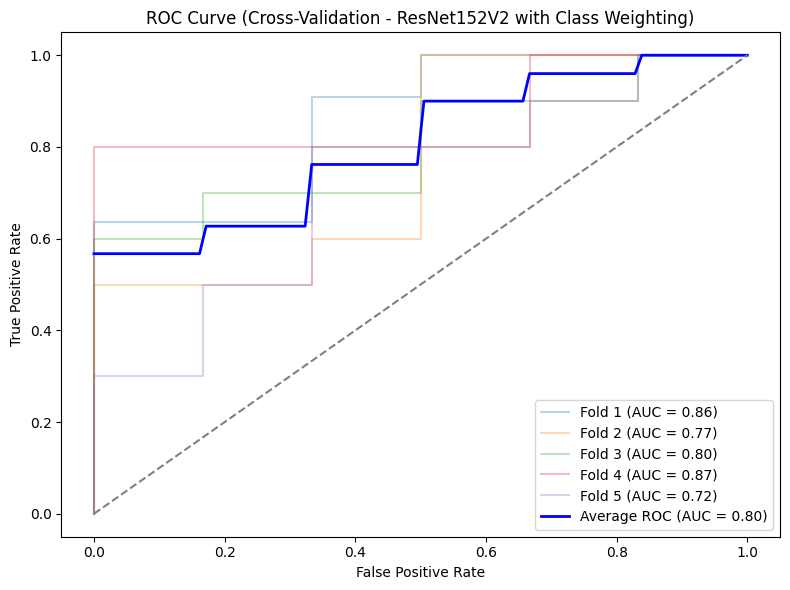

In [ ]:
# ===============================================================================================
# ============================ SEGMENTED IMAGE LOADING & PREPROCESSING ==========================
# ===============================================================================================
# Convert the list of segmented images from U-NET into a NumPy array
segmented_images = np.array(segmented_images)  # shape: (N, 128, 128, 1)

# Convert string labels ("closed"/"open") into binary values (0/1)
label_list = list(labels.values())
segmented_labels = np.array([0 if label == 'closed' else 1 for label in label_list])

# Show counts of each class
unique, counts = np.unique(segmented_labels, return_counts=True)
class_distribution = dict(zip(unique, counts))
print(f"\n Total Segmented Images: {len(segmented_labels)}")
print(f" Class Distribution: {class_distribution} (0=closed, 1=open)")

# Shuffle the dataset to ensure randomness
segmented_images, segmented_labels = shuffle(segmented_images, segmented_labels, random_state=42)

# Split the dataset into training and testing sets (75% train, 25% test)
X_train, X_test, y_train, y_test = train_test_split(
    segmented_images, segmented_labels, stratify=segmented_labels, test_size=0.25, random_state=42
)
print(f"\n Split Summary:")
print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


# Convert grayscale images to 3-channel RGB by repeating channels
X_train = np.repeat(X_train, 3, axis=-1)
X_test = np.repeat(X_test, 3, axis=-1)

# Normalize pixel values to [0, 1] for faster convergence during training
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# --- initialize variables and Clear previous models ---
img_size = 128
tf.keras.backend.clear_session()





# ============================ MODEL INITIALIZATION & CLASSIFICATION ==========================
# Load ResNet152V2 without top classification layer and freeze its weights initially
base_model = tf.keras.applications.ResNet152V2(
    weights='imagenet',
    input_shape=(img_size, img_size, 3),
    include_top=False,
    name='resnet152v2'
)
base_model.trainable = False

# Define a function to build the custom model on top of ResNet base
def get_pretrained():
    inputs = layers.Input(shape=(img_size, img_size, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    output = layers.Dense(2, activation='softmax')(x)  # Binary classification
    model = Model(inputs=inputs, outputs=output)
    return model

# Fine-tune only the last few layers of ResNet
base_model.trainable = True
for layer in base_model.layers[:-10]:
    layer.trainable = False





# ============================ CROSS-VALIDATION SETUP ============================
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracy_scores, precision_scores, recall_scores, f1_scores = [], [], [], []
conf_matrices, fpr_list, tpr_list, auc_list = [], [], [], []
histories = []
total_runtime = 0.0




# ===============================================================================================
# ============================ TRAINING & VALIDATION LOOP =======================================
# ===============================================================================================
# --- 5-Fold Cross-validation Loop ---
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train), 1):
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

    # Compute class weights to address class imbalance
    class_weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train_fold),
        y=y_train_fold
    )
    class_weights_dict = dict(enumerate(class_weights))

    # Create and compile the model
    model_pretrained = get_pretrained()
    model_pretrained.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
        metrics=['accuracy']
    )

    # Train the model
    start_time = time.time()
    history = model_pretrained.fit(
        X_train_fold, y_train_fold,
        validation_data=(X_val_fold, y_val_fold),
        epochs=10,
        batch_size=32,
        class_weight=class_weights_dict,
        verbose=0
    )
    fit_time = time.time() - start_time
    total_runtime += fit_time
    histories.append(history)



# ===============================================================================================
# ============================ EVALUATION ======================================================
# ===============================================================================================
    # Predict and evaluate the validation fold
    y_val_proba = model_pretrained.predict(X_val_fold)
    y_val_pred = np.argmax(y_val_proba, axis=1)

    acc = accuracy_score(y_val_fold, y_val_pred)
    prec = precision_score(y_val_fold, y_val_pred)
    rec = recall_score(y_val_fold, y_val_pred)
    f1 = f1_score(y_val_fold, y_val_pred)

    # Append metrics for this fold
    accuracy_scores.append(acc)
    precision_scores.append(prec)
    recall_scores.append(rec)
    f1_scores.append(f1)

    # Store confusion matrix
    cm = confusion_matrix(y_val_fold, y_val_pred)
    conf_matrices.append(cm)

    # Compute and store ROC curve
    fpr, tpr, _ = roc_curve(y_val_fold, y_val_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    auc_list.append(roc_auc)

    # Print fold summary
    print(f"Fold {fold}: Accuracy={acc:.4f}, Precision={prec:.4f}, Recall={rec:.4f}, F1={f1:.4f}, AUC={roc_auc:.4f}")


    # --- Plot Confusion Matrix ---
    plt.figure()
    plt.imshow(cm, cmap='Blues')
    plt.title(f'Confusion Matrix - Fold {fold}')
    plt.colorbar()
    plt.xticks([0, 1], ['Closed', 'Open'])
    plt.yticks([0, 1], ['Closed', 'Open'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i, j], ha='center', va='center', color='black')
    plt.tight_layout()
    plt.show()

    # --- Plot Loss and Accuracy Curves ---
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'Loss Curve - Fold {fold}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'Accuracy Curve - Fold {fold}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# --- Print Final Results Across All Folds ---
print("\n--- Cross-validated Metrics for ResNet152V2 ---")
print(f"Accuracy scores (by fold): {accuracy_scores}")
print(f"Mean Accuracy: {np.mean(accuracy_scores):.4f}")
print(f"Precision scores (by fold): {precision_scores}")
print(f"Mean Precision: {np.mean(precision_scores):.4f}")
print(f"Recall scores (by fold): {recall_scores}")
print(f"Mean Recall: {np.mean(recall_scores):.4f}")
print(f"F1 scores (by fold): {f1_scores}")
print(f"Mean F1-Score: {np.mean(f1_scores):.4f}")
print(f"Total Runtime (cross-validation): {total_runtime:.2f} seconds")

# --- Aggregate Confusion Matrix from All Folds ---
total_cm = np.sum(conf_matrices, axis=0)
print(f"\nTotal Confusion Matrix (all folds combined):\n{total_cm}")

# --- Average ROC Curve Plot ---
mean_fpr = np.linspace(0, 1, 100)
mean_tpr = np.mean([np.interp(mean_fpr, fpr_list[i], tpr_list[i]) for i in range(len(fpr_list))], axis=0)
mean_auc = auc(mean_fpr, mean_tpr)

plt.figure(figsize=(8, 6))
for i in range(len(fpr_list)):
    plt.plot(fpr_list[i], tpr_list[i], alpha=0.3, label=f'Fold {i+1} (AUC = {auc_list[i]:.2f})')

plt.plot(mean_fpr, mean_tpr, color='blue', lw=2, label=f'Average ROC (AUC = {mean_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

plt.title("ROC Curve (Cross-Validation - ResNet152V2 with Class Weighting)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


- From the plots, it appears that across all folds, the model is likely overfitting,reflected from the widening gap between training and validation loss. Additionally, the validation accuracy decreases as the training accuracy increases, further highlighting this issue. As a result, performance across all metrics is generally lower compared to when raw images were used, with an average AUC of just 0.8 and predictions mostly favoring the majority class in the confusion matrix.


- To further validate this behavior, Grad-CAM has been applied below to confirm whether the model is focusing on the correct features.



### Grad-CAM Heatmap Visualisations

For Grad-CAM, the last convolutional layer is preferred because it captures high-level semantic features that are closely related to the model's final decision.(Selvaraju et al., 2017).

In [ ]:
# ===============================================================================================
# ============================ GRAD-CAM HEATMAP GENERATION ======================================
# ===============================================================================================
# --- Function to Generate Grad-CAM Heatmap ---
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):

    # Create that outputs the feature maps and the predictionsa new model
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Start recording the gradients using GradientTape
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)

        # For binary classification, use the single output channel, for multi-class, use the predicted class index
        if predictions.shape[-1] == 1:
            class_channel = predictions[:, 0]  # Binary classification
        else:
            pred_index = tf.argmax(predictions[0])  # Get the index of the predicted class for multi-class
            class_channel = predictions[:, pred_index]

    # Compute the gradients of the predicted class with respect to the feature map of the last convolutional layer
    grads = tape.gradient(class_channel, conv_outputs)
    conv_outputs = conv_outputs[0]
    grads = grads[0]

    # Pool the gradients across all axes except for the depth dimension
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

    # Multiply the pooled gradients with the feature map, sum over all channels to get the heatmap
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)

    # ReLU activation (to keep only positive gradients) and normalize the heatmap
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + tf.keras.backend.epsilon())

    return heatmap.numpy()

# --- Set the Last Convolutional Layer Name for ResNet152V2 ---
last_conv_layer_name = 'conv5_block3_out'  # This layer name may vary depending on the model architecture





# ===============================================================================================
# ============================ IMAGE LOADING & PREPROCESSING FOR GRAD-CAM =======================
# ===============================================================================================
# --- Image Path Setup ---
img_path = './segmented_data_combined/closed_91.png'  # Path to the input image for Grad-CAM

# Load and preprocess the image (resize to match model input size)
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(128, 128), color_mode='rgb')
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Normalize pixel values to [0, 1]

# --- Image Path Setup ---
img_path = './segmented_data_combined/open_3.png'  # Path to the input image for Grad-CAM

# Load and preprocess the image (resize to match model input size)
img1 = tf.keras.preprocessing.image.load_img(img_path, target_size=(128, 128), color_mode='rgb')
img_array1 = tf.keras.preprocessing.image.img_to_array(img)
img_array1 = np.expand_dims(img_array1, axis=0)  # Add batch dimension
img_array1 = img_array1 / 255.0  # Normalize pixel values to [0, 1]

Configuration of Last Convulation layer

In [ ]:
# --- Automatically Detect Last Conv2D Layer ---
# Loop through model layers to find the last Conv2D layer if not specified
for layer in reversed(model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_layer_name = layer.name
        break

print("Last Conv Layer:", last_conv_layer_name)  # Print the name of the last convolutional layer



Last Conv Layer: conv2d_18


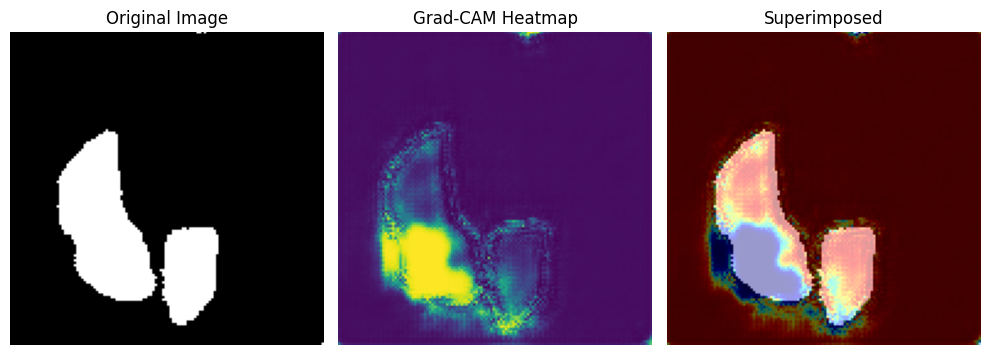

In [ ]:
# --- Generate the Grad-CAM Heatmap ---
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# --- Load the Original Image for Display ---
original_img = cv2.imread(img_path)
original_img = cv2.resize(original_img, (128, 128))  # Ensure same size as model input
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

# --- Resize Heatmap to Match Image Dimensions ---
heatmap_resized = cv2.resize(heatmap, (128, 128))  # Resize heatmap to the image size
heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)  # Apply colormap

# --- Superimpose Heatmap on Original Image ---
superimposed_img = cv2.addWeighted(original_img, 0.6, heatmap_colored, 0.4, 0)  # Blend the heatmap with the original image

# --- Display the Results ---
plt.figure(figsize=(10, 4))

# Original image
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(original_img)
plt.axis('off')

# Grad-CAM heatmap
plt.subplot(1, 3, 2)
plt.title("Grad-CAM Heatmap")
plt.imshow(heatmap, cmap='viridis')  # Use 'viridis' colormap for better visibility
plt.axis('off')

# Superimposed image (Original + Grad-CAM heatmap)
plt.subplot(1, 3, 3)
plt.title("Superimposed")
plt.imshow(superimposed_img)
plt.axis('off')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

- From the pictures, although the heatmap highlights some relevant regions within the segmentation, the uneven focus (concentrated on lower parts) and activation slightly spill-over beyond actual heart boundaries confirm the model fails to learn robust, generalizable features.

- Hence, the suboptimal performance of ResNet152V2 on segmented heart ultrasound images is likely due to the fact that the dataset, comprising only 109 images with just 81 used for training, was insufficient for a model with over 60 million parameters. Additionally, class imbalance further contributed to overfitting. Moreover, the quality of the segmented images was suboptimal, as the U-Net model was trained on a very small dataset (only 50% of the annotated masks used).

## **REFERENCES**

In [ ]:
# ==============================================================================================
# ============================ LIST OF REFERENCES===============================================
# ==============================================================================================

# • Selvaraju, R.R., Cogswell, M., Das, A., Vedantam, R., Parikh, D. and Batra, D. (2017) ‘Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization’, Proceedings of the IEEE International Conference on Computer Vision (ICCV), pp. 618–626. Available at: https://doi.org/10.1109/ICCV.2017.74.
# • He, K., Zhang, X., Ren, S. and Sun, J. (2016) ‘Identity mappings in deep residual networks’, in European Conference on Computer Vision (ECCV), pp. 630–645. Springer.
# • Kaggle (no date) US Simulation and Segmentation Challenge Dataset. Available at: https://www.kaggle.com/datasets/ignaciorlando/ussimandsegm (Accessed: 03 April 2025).
# • Alriffaud, A. (2021) Transfer Learning with ResNet152V2 for CIFAR-10 Classification. Available at: https://medium.com/@alriffaud/transfer-learning-with-resnet152v2-for-cifar-10-classification-d934271151d6 (Accessed: 03 April 2025).
# • Orlando, J.I. et al. (2021) Ultrasound Simulation and Segmentation Challenge Dataset. Available at: https://www.kaggle.com/datasets/ignaciorlando/ussimandsegm (Accessed: 05 April 2025).
# • TensorFlow (no date) Image Segmentation using Deep Learning. Available at: https://www.tensorflow.org/tutorials/images/segmentation (Accessed: 04 April 2025).
# • TensorFlow (no date) tf.keras.applications.ResNet152V2. Available at: https://www.tensorflow.org/api_docs/python/tf/keras/applications/ResNet152V2 (Accessed: 01 April 2025).
# • YouTube (2021) Grad-CAM | Visualize CNN decisions with class activation maps, YouTube. Available at: https://www.youtube.com/watch?v=IHq1t7NxS8k (Accessed: 08 April 2025).
# • YouTube (2021) Visualizing Class Activation Maps with Grad-CAM, YouTube. Available at: https://www.youtube.com/watch?v=Y8mSngdQb9Q (Accessed: 08 April 2025).
# • YouTube (2023) Grad-CAM Implementation in TensorFlow/Keras, YouTube. Available at: https://www.youtube.com/watch?v=x5Pz0N_exz8 (Accessed: 08 April 2025).
# • ResearchGate (no date) ResNet101V2 and ResNet152V2 architecture visualization. Available at: https://www.researchgate.net/figure/ResNet101V2-and-ResNet152V2-architecture-with-extra-layers-added-at-the-end-for_fig4_353225711 (Accessed: 07 April 2025).
